<a href="https://colab.research.google.com/github/aimikawaguchi/PEMTOS_Prediction/blob/main/PEMTOS_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PEMTOS Prediction Method**
This multivariate time-seires pipeline enables to produce an out-of-sample prediction without predicting independent variables. You will just have to set dates that you would like to use and predict, and the rest will be taken care of by PEMTOS.

**Steps:**\
Phase 1. Data preprocessing\
Phase 2. In-sample prediction to define golden baseline\
Phase 3. Out-of-sample prediction\
Phase 4. Prediction Outcome\
Phase 5. Feature importance\
Phase 6. Statistical Analysis



# Importing packages

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
from glob import glob as gg
from functools import reduce

import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.stattools import adfuller
from statsmodels.formula.api import ols

import scipy.stats as sp
from scipy.special import ndtri

import itertools 
from fbprophet import Prophet
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import tree

# company's color palette
colors = ['#0051BA', '#FFDA1A'] 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def dropduplicates_on_Date(dataframe):
  dataframe = dataframe.drop_duplicates(subset='Date', keep='first')

In [ ]:
def feature_cleaning(dataframe):
  dataframe["Date"] = pd.to_datetime(dataframe["Date"])
  dataframe = dataframe.drop_duplicates()
  

In [ ]:
def past_years_future_valuesues(feature_dataframe):
  for i in feature_futuredays:
    count_a = len(feature_dataframe)
    pastyears = feature_dataframe.iloc[count_a - 2*365: count_a + 1 : 365] # all values from 2 years
    my_date = feature_dataframe.index[-1]
    my_date += dt.timedelta(days = 1)
    feature_dataframe.loc[my_date] = pastyears.median()

In [ ]:
def rolling_average_14days_future_values(feature_dataframe):
  # remove unnecessary variables as there could be local-global variable confusion
   for _ in feature_futuredays:
    #  Update the date
      my_date = feature_dataframe.index[-1] 
      my_date += dt.timedelta(days = 1) 
      # Update the date with rolling median
      feature_dataframe.loc[my_date] = feature_dataframe.iloc[:-14,:].median()


In [ ]:
def rolling_average_30days_future_values(feature_dataframe):
  # remove unnecessary variables as there could be local-global variable confusion
   for _ in feature_futuredays:
    #  Update the date
      my_date = feature_dataframe.index[-1] 
      my_date += dt.timedelta(days = 1) 
      # Update the date with rolling median
      feature_dataframe.loc[my_date] = feature_dataframe.iloc[:-30,:].median()

      

In [ ]:
def mean_of_day_of_the_week_from_past_14days(feature_dataframe):
  # Loop through 35 consecutive days
  for _ in (feature_futuredays):
    pastweeks = feature_dataframe.iloc[-14:] # all values from the past 30 days
    my_date = feature_dataframe.index[-1] # get value of the last index for median
    my_date += dt.timedelta(days = 1) # increase the dates table
    feature_dataframe.loc[my_date] = pastweeks[pastweeks.index.day_name()==my_date.day_name()].median() # Median of the values of that particular day in 30 days  and insert the value at the end 

In [ ]:
def mean_of_day_of_the_week_from_past_30days(feature_dataframe):
  # Loop through 35 consecutive days
  for _ in (feature_futuredays):
    pastweeks = feature_dataframe.iloc[-30:] # all values from the past 30 days
    my_date = feature_dataframe.index[-1] # get value of the last index for median
    my_date += dt.timedelta(days = 1) # increase the dates table
    feature_dataframe.loc[my_date] = pastweeks[pastweeks.index.day_name()==my_date.day_name()].median() # Median of the values of that particular day in 30 days  and insert the value at the end 

In [ ]:
def variance(data):
  # Number of observations
  n = len(data)
  # Mean of the data
  mean = sum(data) / n
  # Square deviations
  deviations = [(x - mean) ** 2 for x in data]
     # Variance
  variance = sum(deviations) / n
  return variance

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

# Pre-Set: Date Range and Prediction Period(*)



When you upload the data files, you can adjust how many days of data you want to use for the prediction. This date selection applies to the entire data set. To do so, change the date range of "start" and "end".

Also, when you can set how many days you want to predict by changing the value of "test_days" and "cv_test_days".

"prophet_cv_initial" has to be within a range of the "new_date_range" - "test_days". To check how many days are in the range, you can use the link below.

Date Range Check: [Link](https://planetcalc.com/274/)

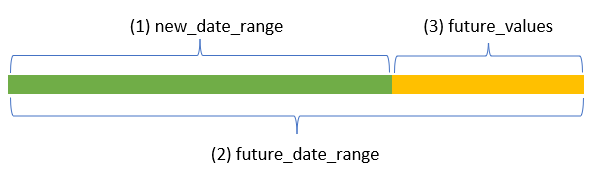


In [ ]:
#General Keys
#(1) set a data range of the testing phase (2) and including tain and test
new_date_range  = pd.date_range(start="2020-01-01", end="2022-05-14", freq="D")

#(2) set a date range of start to end including the future prediction (100% of (1) for train, and predict 35 days ahead)
'''Recommendation: the end date of "new_date_range" + 5 weeks (prediction period) >> Check the calender'''
future_date_range =  pd.date_range(start="2020-01-01", end="2022-6-19", freq="D")

#(3) set a date range of the empty future values without existing data (The future 35 days) >> For graph
future_values = pd.date_range(start = '2022-05-15', end ='2022-06-19', freq = 'D')

In [ ]:
test_days = 35     # Phase 2; 5 weeks testing with existing values
feature_futuredays = range(35)     # Phase 3: 5 weeks in the future

# **Phase 1: Data Preprocessing**

In this section, all uploaded data are cleaned to eliminate outliers or fill milling values. Please review the graphs of each tab to detect any irregular behavior in data.

# Volume of Call

In [ ]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Python Dataset/Macro Template Simple.csv')

In [ ]:
#Load csv files from a folder Google Mobility
df_list = []
for f in sorted(gg('/content/drive/MyDrive/Python Dataset/Actual Value/V*.txt')):
    df_list.append(pd.read_csv(f, skiprows = 2, sep=","))
vol = pd.concat(df_list, axis=0, ignore_index=True)
vol = vol[['Date', 'Volume (Absolute Act)']]
vol = vol.drop_duplicates()

In [ ]:
# Check the country code of the Netherlands
vol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1003 entries, 0 to 1002
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Date                   1003 non-null   object
 1   Volume (Absolute Act)  1003 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.5+ KB


In [ ]:
# rename features
volume_n = vol.rename(columns={'Volume (Absolute Act)': 'Demand(y)'})
volume_ground = volume_n.loc[:, ['Date', 'Demand(y)']]

In [ ]:
volume_ground.to_csv('demand_counts_daily.csv')

In [ ]:
# Apply function for fearture organization and cleaning
feature_cleaning(volume_ground)

In [ ]:
# # Set date as index 
volume_ground.set_index('Date', inplace=True)
volume_ground = volume_ground.asfreq("D")
volume_ground.sort_values(by='Date', ascending=True)

Demand(y)
Date                 
2019-09-02     2742.0
2019-09-03     2398.0
2019-09-04     2548.0
2019-09-05     2019.0
2019-09-06     2322.0
...               ...
2022-06-08     2344.0
2022-06-09     2062.0
2022-06-10     2011.0
2022-06-11     1274.0
2022-06-12      686.0

[1015 rows x 1 columns]

In [ ]:
volume_ground.loc[(volume_ground['Demand(y)'] == 0)]

Demand(y)
Date                 
2020-05-24        0.0
2020-06-07        0.0
2020-06-14        0.0
2020-06-21        0.0
2020-06-28        0.0
...               ...
2020-08-02        0.0
2020-08-09        0.0
2020-08-16        0.0
2020-08-23        0.0
2020-08-30        0.0

[14 rows x 1 columns]

In [ ]:
# fill missing values 
volume_ground = volume_ground.fillna(0)

In [ ]:
# #Set date range
volume_ground1 = volume_ground.reindex(new_date_range)

In [ ]:
volume_ground1

Demand(y)
2020-01-01        0.0
2020-01-02     2288.0
2020-01-03     2129.0
2020-01-04     1354.0
2020-01-05     1045.0
...               ...
2022-05-10     1938.0
2022-05-11     1700.0
2022-05-12     1729.0
2022-05-13     1782.0
2022-05-14     1058.0

[865 rows x 1 columns]

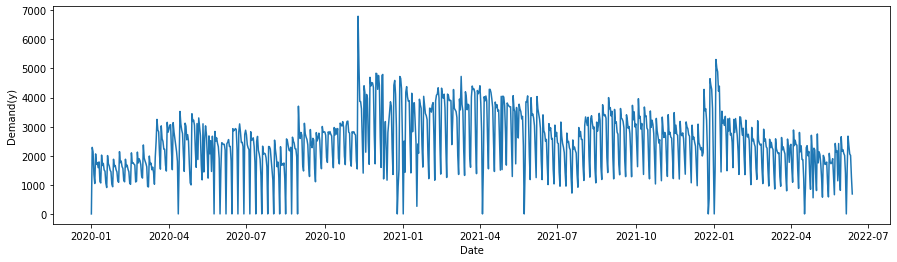

In [ ]:
plt.figure(figsize=(15,4))
sns.lineplot(data = volume_ground['Demand(y)']['2020-01-01':], palette = colors)

In [ ]:
cv_dfs = [volume_ground]
cv_dfs = pd.concat(cv_dfs, join='outer', axis=1)
cols= cv_dfs.columns

# create empty list for CV
cv_list = []

# same loop but append cv_data to list each time
for column in cv_dfs.columns:
  cv_data = sp.variation(cv_dfs[column], nan_policy = 'omit')#.sort_values(ascending=False)
  cv_data = round(cv_data*100, 2)
  print("{}: {}%".format(column, cv_data))
  cv_list.append(cv_data)


# create new dataframe with column name "value" and data as cv_list
df_vnew = pd.DataFrame(cv_list, columns=['value'])

# set index names and values
df_vnew.index = [cols]
df_vnew.index.name = 'column_name'
# # print new dataframe
# print(df_new)

Demand(y): 41.85%


# Google Community Report

In [ ]:
#Load csv files from a folder Google Mobility
df_list = []
for f in sorted(gg('/content/drive/MyDrive/Python Dataset/Covid/Google_Mobility/20*_NL_*.csv')):
    df_list.append(pd.read_csv(f, sep=","))
GM_combined = pd.concat(df_list, axis=0, ignore_index=True)
GM_combined = GM_combined.drop_duplicates()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
GM_combined = GM_combined.rename(columns={'date': 'Date'})
feature_cleaning(GM_combined)
GM_combined.sort_values(by='Date', ascending=True)


GM_region_1 = GM_combined.loc[(GM_combined['place_id'] != 'ChIJu-SH28MJxkcRnwq9_851obM')]

In [ ]:
#create DataFrame per sub_region_1 and groupby the date while averaging out values of each columns per day.
#(1)
GM_region_1_list = list(GM_region_1['sub_region_1'].unique())
GM_region_1_dict = dict()

for region in GM_region_1_list:
    GM_region_1_dict[region] = GM_region_1.loc[(GM_region_1['sub_region_1'] == region)]

GM_region_1_dict.keys()

dict_keys(['Drenthe', 'Flevoland', 'Friesland', 'Gelderland', 'Groningen', 'Limburg', 'North Brabant', 'North Holland', 'Overijssel', 'South Holland', 'Utrecht', 'Zeeland'])

In [ ]:
columns = ['retail_and_recreation_percent_change_from_baseline',
           'parks_percent_change_from_baseline'
           ]

#Create new dataframs of each region in sub_region_1
for region_name, region_df in GM_region_1_dict.items():
       #indicate the location of outcome to be saved
       save_path = f"./GM_outputs/{region_name}"

       #create df in metrics of Mean, Median, and Std.
       region_mean = region_df.groupby('Date', as_index=False, sort=True)[columns].mean()
       region_median = region_df.groupby('Date', as_index=False, sort=True)[columns].median()
       region_std = region_df.groupby('Date', as_index=False, sort=True)[columns].std()
       
       #rename the each columns with region name/metric type/column
       rename_dict = {
              'retail_and_recreation_percent_change_from_baseline': f'{region_name}_Metric_Retail_Rec_%Change', 
              'parks_percent_change_from_baseline': f'{region_name}_Metric_Park_%Change',
       }
       region_mean = region_mean.rename(columns=dict(
              map(lambda x: (x[0], x[1].replace('Metric', 'Ave')), rename_dict.items())))
       region_median = region_median.rename(columns=dict(
              map(lambda x: (x[0], x[1].replace('Metric', 'Mid')), rename_dict.items())))
       region_std = region_std.rename(columns=dict(
              map(lambda x: (x[0], x[1].replace('Metric', 'Std')), rename_dict.items())))
       
       save_columns_list = ['Date', 
                            f'{region_name}_Metric_Retail_Rec_%Change', 
                            f'{region_name}_Metric_Park_%Change'
                            ]
 
       region_mean = region_mean[list(map(lambda x: x.replace('Metric', 'Ave'), save_columns_list))].copy()
       region_median = region_median[list(map(lambda x: x.replace('Metric', 'Mid'), save_columns_list))].copy()
       region_std = region_std[list(map(lambda x: x.replace('Metric', 'Std'), save_columns_list))].copy()

       #each file is saved in the path and ready to merge with Volume
       os.makedirs(save_path, exist_ok=True)
       region_mean.to_csv(f"{save_path}/{region_name}_GM_mean.csv", index = False)
       region_median.to_csv(f"{save_path}/{region_name}_GM_median.csv", index = False)
       region_std.to_csv(f"{save_path}/{region_name}_GM_std.csv", index = False)

In [ ]:
mobility = pd.DataFrame()

for f in gg('/content/GM_outputs/*/*.csv'):
    tmp = pd.read_csv(f)
    mobility = pd.concat([mobility,tmp],axis=1,ignore_index=False)

In [ ]:
mobility = mobility.loc[:,~mobility.columns.duplicated()]
mobility["Date"] = pd.to_datetime(mobility["Date"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#indexed the date column
mobility.set_index('Date', inplace=True)
mobility = mobility.asfreq("D")


# fill null values
mobility.fillna(method = 'ffill', inplace = True)

In [ ]:
#select the date range
mobility1 = mobility.reindex(new_date_range)

# fill null values
mobility1.fillna(method = 'ffill', inplace = True)

In [ ]:
#select the date range
mobility1 = mobility1.reindex(new_date_range)

In [ ]:
mobility1

Drenthe_Ave_Retail_Rec_%Change  Drenthe_Ave_Park_%Change  \
2020-01-01                             NaN                       NaN   
2020-01-02                             NaN                       NaN   
2020-01-03                             NaN                       NaN   
2020-01-04                             NaN                       NaN   
2020-01-05                             NaN                       NaN   
...                                    ...                       ...   
2022-05-10                        4.285714                124.000000   
2022-05-11                        6.571429                 70.000000   
2022-05-12                        5.125000                 58.000000   
2022-05-13                       -3.125000                 86.400000   
2022-05-14                        5.200000                101.333333   

            Drenthe_Std_Retail_Rec_%Change  Drenthe_Std_Park_%Change  \
2020-01-01                             NaN                       NaN   
2020-01-02                             NaN                       NaN   
2020-01-03                             NaN                       NaN   
2020-01-04                             NaN                       NaN   
2020-01-05                             NaN                       NaN   
...                                    ...                       ...   
2022-05-10                        8.260635                 39.239861   
2022-05-11                        9.144345                 80.610173   
2022-05-12                       10.370804                 70.710678   
2022-05-13                        7.605214                 22.667157   
2022-05-14                       17.370473                 61.158265   

            Drenthe_Mid_Retail_Rec_%Change  ...  Overijssel_Std_Park_%Change  \
2020-01-01                             NaN  ...                          NaN   
2020-01-02                             NaN  ...                          NaN   
2020-01-03                             NaN  ...                          NaN   
2020-01-04                             NaN  ...                          NaN   
2020-01-05                             NaN  ...                          NaN   
...                                    ...  ...                          ...   
2022-05-10                             3.0  ...                    31.112698   
2022-05-11                             5.0  ...                    33.941125   
2022-05-12                             2.5  ...                    43.840620   
2022-05-13                            -2.5  ...                    49.409851   
2022-05-14                             1.0  ...                    58.689863   

            Overijssel_Ave_Retail_Rec_%Change  Overijssel_Ave_Park_%Change  \
2020-01-01                                NaN                          NaN   
2020-01-02                                NaN                          NaN   
2020-01-03                                NaN                          NaN   
2020-01-04                                NaN                          NaN   
2020-01-05                                NaN                          NaN   
...                                       ...                          ...   
2022-05-10                           5.062500                    79.000000   
2022-05-11                           5.500000                    92.000000   
2022-05-12                           5.705882                    49.000000   
2022-05-13                           4.111111                    72.333333   
2022-05-14                           7.400000                   114.500000   

            Overijssel_Mid_Retail_Rec_%Change  Overijssel_Mid_Park_%Change  
2020-01-01                                NaN                          NaN  
2020-01-02                                NaN                          NaN  
2020-01-03                                NaN                          NaN  
2020-01-04                                NaN                          NaN  

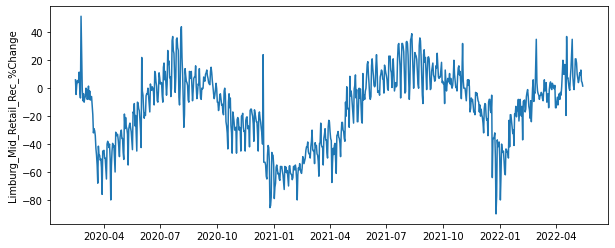

In [ ]:
plt.figure(figsize=(10,4))
sns.lineplot(data = mobility1['Limburg_Mid_Retail_Rec_%Change'], palette = colors)

# Weather

In [ ]:
#Load csv files from a folder Google Mobility
df_list = []
for f in sorted(gg('/content/drive/MyDrive/Python Dataset/Weather/result*.txt')):
    df_list.append(pd.read_csv(f, skiprows=95))
weather = pd.concat(df_list, axis=0, ignore_index=True)
weather = weather.drop_duplicates()

In [ ]:
#Change the datatypes
#datetime object
weather.columns = weather.columns.str.strip()
weather = weather.rename(columns={'YYYYMMDD': 'Date'})
weather["Date"] = pd.to_datetime(weather["Date"], format = "%Y%m%d")
weather.sort_values(by='Date', ascending=True)
weather = weather.drop_duplicates()

#integer to object
weather["# STN"] = weather["# STN"].astype(str)

weather = weather[['# STN', 'Date', 'DDVEC', 'FHVEC', 'FG', 'FXX',  'TG', 'TN', 'TX', 'SQ', 'NG', 'RH']].copy()

#select the data types
columns = ['DDVEC', 'FHVEC', 'FG', 'FXX',  'TG', 'TN', 'TX', 'SQ', 'NG', 'RH']

#change the data types from object to float in the selected columns
weather[columns] = weather[columns].apply(pd.to_numeric, errors = 'coerce', axis = 1)
weather["RH"] = weather['RH'].apply(lambda x:0.05 if x == 0.1 else x)

In [ ]:
# Remove useless stations with entirely null values
weather = weather.loc[(weather['# STN'] != '308')]
weather = weather.loc[(weather['# STN'] != '313')]
weather = weather.loc[(weather['# STN'] != '331')]

In [ ]:
#group by per day
#take median of each station
weather = weather.groupby('Date', as_index=True, sort=True)[columns].median()

In [ ]:
weather.fillna(method = 'ffill', inplace = True)

In [ ]:
# Set the date range
weather1 = weather.reindex(new_date_range)

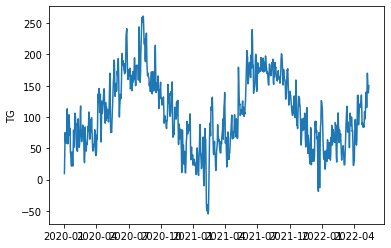

In [ ]:
sns.lineplot(data = weather1['TG'], palette = 'g')
# sns.lineplot(data = weather['DDVEC'], palette = 'o')
# sns.lineplot(data = weather['SQ'], palette = 'b')
# sns.lineplot(data = weather['RH'], palette = 'r')


# Holiday

In [ ]:
holi = pd.read_excel('/content/drive/MyDrive/Python Dataset/Holiday/Holidays.xlsx')
holi = holi.drop_duplicates()

In [ ]:
feature_cleaning(holi)

In [ ]:
#fill non sales dates with zero
holi = holi.fillna(0)
holi.isnull().sum()

#Set the Sales_Offered as binary
holi['Holidays'] = holi['Holidays'].astype('bool')
holi['christmas_NY'] = holi['christmas_NY'].astype('bool')
holi['easter_whit'] = holi['easter_whit'].astype('bool')

#One Hot Encoding on the day of the week
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(holi[['Day_of_Week']]).toarray())
holi = holi.join(encoder_df)

#indexed the date column
holi.set_index('Date', inplace=True)
holi = holi.asfreq("D")

In [ ]:
holi = holi.rename(columns={0: 'Fri',
                                    1: 'Mon',
                                    2: 'Sat',
                                    3: 'Sun',
                                    4: 'Thu',
                                    5: 'Tue',
                                    6: 'Wed'                             
})

In [ ]:
holi = holi[['Holidays', 'christmas_NY', 'easter_whit', 
      'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', ]]

In [ ]:
#Set date range
holi1 = holi.reindex(new_date_range)
holi1

Holidays  christmas_NY  easter_whit  Mon  Tue  Wed  Thu  Fri  Sat  \
2020-01-01      True          True        False  0.0  0.0  1.0  0.0  0.0  0.0   
2020-01-02      True         False        False  0.0  0.0  0.0  1.0  0.0  0.0   
2020-01-03      True         False        False  0.0  0.0  0.0  0.0  1.0  0.0   
2020-01-04      True         False        False  0.0  0.0  0.0  0.0  0.0  1.0   
2020-01-05      True         False        False  0.0  0.0  0.0  0.0  0.0  0.0   
...              ...           ...          ...  ...  ...  ...  ...  ...  ...   
2022-05-10     False         False        False  0.0  1.0  0.0  0.0  0.0  0.0   
2022-05-11     False         False        False  0.0  0.0  1.0  0.0  0.0  0.0   
2022-05-12     False         False        False  0.0  0.0  0.0  1.0  0.0  0.0   
2022-05-13     False         False        False  0.0  0.0  0.0  0.0  1.0  0.0   
2022-05-14     False         False        False  0.0  0.0  0.0  0.0  0.0  1.0   

            Sun  
2020-01-01  0.0  
2020-01-02  0.0  
2020-01-03  0.0  
2020-01-04  0.0  
2020-01-05  1.0  
...         ...  
2022-05-10  0.0  
2022-05-11  0.0  
2022-05-12  0.0  
2022-05-13  0.0  
2022-05-14  0.0  

[865 rows x 10 columns]

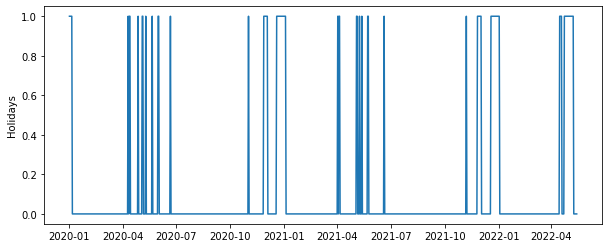

In [ ]:
plt.figure(figsize=(10,4))
sns.lineplot(data = holi1['Holidays'], palette = colors)

# Covid Stringency Index

In [ ]:
#Load csv files from a folder
df_list = []
for f in sorted(gg('/content/drive/MyDrive/Python Dataset/Covid/Stringency_Index/owid-covid*.csv')):
    df_list.append(pd.read_csv(f, sep=","))
stringency = pd.concat(df_list, axis=0, ignore_index=True)
stringency = stringency.drop_duplicates()

In [ ]:
stringency

iso_code continent     location        date  total_cases  ...  \
0           AFG      Asia  Afghanistan  2020-02-24          5.0  ...   
1           AFG      Asia  Afghanistan  2020-02-25          5.0  ...   
2           AFG      Asia  Afghanistan  2020-02-26          5.0  ...   
3           AFG      Asia  Afghanistan  2020-02-27          5.0  ...   
4           AFG      Asia  Afghanistan  2020-02-28          5.0  ...   
...         ...       ...          ...         ...          ...  ...   
197689      ZWE    Africa     Zimbabwe  2022-06-25     255309.0  ...   
197690      ZWE    Africa     Zimbabwe  2022-06-26     255355.0  ...   
197691      ZWE    Africa     Zimbabwe  2022-06-27     255383.0  ...   
197692      ZWE    Africa     Zimbabwe  2022-06-28     255383.0  ...   
197693      ZWE    Africa     Zimbabwe  2022-06-29     255520.0  ...   

        human_development_index  excess_mortality_cumulative_absolute  \
0                         0.511                                   NaN   
1                         0.511                                   NaN   
2                         0.511                                   NaN   
3                         0.511                                   NaN   
4                         0.511                                   NaN   
...                         ...                                   ...   
197689                    0.571                                   NaN   
197690                    0.571                                   NaN   
197691                    0.571                                   NaN   
197692                    0.571                                   NaN   
197693                    0.571                                   NaN   

        excess_mortality_cumulative  excess_mortality  \
0                               NaN               NaN   
1                               NaN               NaN   
2                               NaN               NaN   
3                               NaN               NaN   
4                               NaN               NaN   
...                             ...               ...   
197689                          NaN               NaN   
197690                          NaN               NaN   
197691                          NaN               NaN   
197692                          NaN               NaN   
197693                          NaN               NaN   

        excess_mortality_cumulative_per_million  
0                                           NaN  
1                                           NaN  
2                                           NaN  
3                                           NaN  
4                                           NaN  
...                                         ...  
197689                                      NaN  
197690                                      NaN  
197691                                      NaN  
197692                                      NaN  
197693                                      NaN  

[197694 rows x 67 columns]

In [ ]:
# select Netherlands data, select necessary columns and change data types
stringency = stringency.rename(columns={'date': 'Date'})
NL_Stringency = stringency.loc[(stringency['location'] == 'Netherlands')]
NL_Stringency = NL_Stringency[['Date', 'stringency_index', 'new_cases_smoothed',
                               'new_deaths_smoothed',
                               ]]

NL_Stringency["Date"] = pd.to_datetime(NL_Stringency["Date"])
NL_Stringency.sort_values(by='Date', ascending=True)
NL_Stringency = NL_Stringency.drop_duplicates()
NL_Stringency.fillna(method = 'ffill', inplace = True)

# set date index
NL_Stringency.set_index('Date', inplace=True)
NL_Stringency = NL_Stringency.asfreq("D")

#Set date range
NL_Stringency1 = NL_Stringency.reindex(new_date_range)

In [ ]:
NL_Stringency.columns

Index(['stringency_index', 'new_cases_smoothed', 'new_deaths_smoothed'], dtype='object')

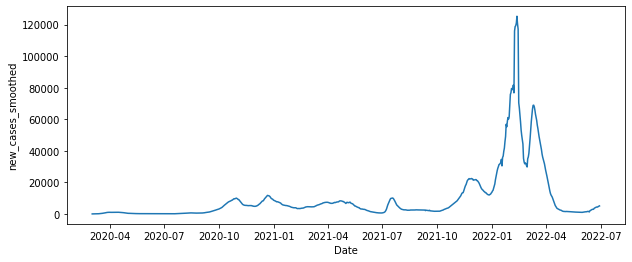

In [ ]:
plt.figure(figsize=(10,4))
sns.lineplot(data = NL_Stringency['new_cases_smoothed'], palette = colors)

In [ ]:
NL_Stringency1

stringency_index  new_cases_smoothed  new_deaths_smoothed
2020-01-01               NaN                 NaN                  NaN
2020-01-02               NaN                 NaN                  NaN
2020-01-03               NaN                 NaN                  NaN
2020-01-04               NaN                 NaN                  NaN
2020-01-05               NaN                 NaN                  NaN
...                      ...                 ...                  ...
2022-05-10             19.44            1434.143                2.714
2022-05-11             19.44            1393.429                3.000
2022-05-12             19.44            1359.000                3.286
2022-05-13             19.44            1353.429                3.143
2022-05-14             19.44            1331.286                2.857

[865 rows x 3 columns]

# In-Sample Dataset

In this section, all dataframes are going to be merged.

In [ ]:
from functools import reduce
import pandas as pd

dfs = [volume_ground1, mobility1, weather1, holi1,
       NL_Stringency1
       ] # do not include CCI as it is difficult to forecast the value
# nan_value = 0

# solution 1 (fast)
all = pd.concat(dfs, join='outer', axis=1)

In [ ]:
all.columns.nunique()

96

In [ ]:
all.fillna(method = 'ffill', inplace = True)

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

# Out-of-Sample Dataset

---
**Coefficient of Variation (CV)**\
It is a ratio of the standard deviation to the mean. In other words, it evaluates how much variance the dataset has shown in percentage. The higher the value, the higher the variance.
The calculation is Standard Deviation/ Mean. If CV > 1, it indicates a relatively high variation of data, while CV < 1 means less variance. This statistical analysis is benefitial to evaluate which features can be useful to include in the out-of-sample forecasting. It is because even if all features improved the accuracy in in-sample, it doesn't mean it is helpful also for the out-of-sample. Standard Deviation is a common measure of variability, and it is simply the square roof of the variance. However, since it uses the same unit as the original data, it is difficult to use for the feature evaluation since they have different units.







```
CV = 100*Std/Mean
```
---


In [ ]:
cv_dfs = [mobility, NL_Stringency, weather]
cv_dfs = pd.concat(cv_dfs, join='outer', axis=1)

In [ ]:
cv_dfs.head()

Drenthe_Ave_Retail_Rec_%Change  Drenthe_Ave_Park_%Change  \
Date                                                                   
2019-09-02                             NaN                       NaN   
2019-09-03                             NaN                       NaN   
2019-09-04                             NaN                       NaN   
2019-09-05                             NaN                       NaN   
2019-09-06                             NaN                       NaN   

            Drenthe_Std_Retail_Rec_%Change  Drenthe_Std_Park_%Change  \
Date                                                                   
2019-09-02                             NaN                       NaN   
2019-09-03                             NaN                       NaN   
2019-09-04                             NaN                       NaN   
2019-09-05                             NaN                       NaN   
2019-09-06                             NaN                       NaN   

            Drenthe_Mid_Retail_Rec_%Change  Drenthe_Mid_Park_%Change  \
Date                                                                   
2019-09-02                             NaN                       NaN   
2019-09-03                             NaN                       NaN   
2019-09-04                             NaN                       NaN   
2019-09-05                             NaN                       NaN   
2019-09-06                             NaN                       NaN   

            Groningen_Mid_Retail_Rec_%Change  Groningen_Mid_Park_%Change  \
Date                                                                       
2019-09-02                               NaN                         NaN   
2019-09-03                               NaN                         NaN   
2019-09-04                               NaN                         NaN   
2019-09-05                               NaN                         NaN   
2019-09-06                               NaN                         NaN   

            Groningen_Ave_Retail_Rec_%Change  Groningen_Ave_Park_%Change  \
Date                                                                       
2019-09-02                               NaN                         NaN   
2019-09-03                               NaN                         NaN   
2019-09-04                               NaN                         NaN   
2019-09-05                               NaN                         NaN   
2019-09-06                               NaN                         NaN   

            Groningen_Std_Retail_Rec_%Change  Groningen_Std_Park_%Change  \
Date                                                                       
2019-09-02                               NaN                         NaN   
2019-09-03                               NaN                         NaN   
2019-09-04                               NaN                         NaN   
2019-09-05                               NaN                         NaN   
2019-09-06                               NaN                         NaN   

            Zeeland_Std_Retail_Rec_%Change  Zeeland_Std_Park_%Change  \
Date                                                                   
2019-09-02                             NaN                       NaN   
2019-09-03                             NaN                       NaN   
2019-09-04                             NaN                       NaN   
2019-09-05                             NaN                       NaN   
2019-09-06                             NaN                       NaN   

            Zeeland_Mid_Retail_Rec_%Change  Zeeland_Mid_Park_%Change  \
Date                                                                   
2019-09-02                             NaN                       NaN   
2019-09-03                             NaN                       NaN   
2019-09-04                             NaN                       NaN   
2019-09-05                       

In [ ]:
cols= cv_dfs.columns

In [ ]:
# create empty list for CV
cv_list = []

# same loop but append cv_data to list each time
for column in cv_dfs.columns:
  cv_data = sp.variation(cv_dfs[column], nan_policy = 'omit')#.sort_values(ascending=False)
  cv_data = round(cv_data*100, 2)
  print("{}: {}%".format(column, cv_data))
  cv_list.append(cv_data)


# create new dataframe with column name "value" and data as cv_list
df_new = pd.DataFrame(cv_list, columns=['value'])

# set index names and values
df_new.index = [cols]
df_new.index.name = 'column_name'
# # print new dataframe
# print(df_new)

Drenthe_Ave_Retail_Rec_%Change: -248.98%
Drenthe_Ave_Park_%Change: 117.85%
Drenthe_Std_Retail_Rec_%Change: 56.61%
Drenthe_Std_Park_%Change: 72.51%
Drenthe_Mid_Retail_Rec_%Change: -218.56%
Drenthe_Mid_Park_%Change: 118.03%
Groningen_Mid_Retail_Rec_%Change: -135.65%
Groningen_Mid_Park_%Change: 99.86%
Groningen_Ave_Retail_Rec_%Change: -158.82%
Groningen_Ave_Park_%Change: 100.08%
Groningen_Std_Retail_Rec_%Change: 47.58%
Groningen_Std_Park_%Change: 104.94%
Zeeland_Std_Retail_Rec_%Change: 70.83%
Zeeland_Std_Park_%Change: 101.78%
Zeeland_Mid_Retail_Rec_%Change: -9472.43%
Zeeland_Mid_Park_%Change: 113.21%
Zeeland_Ave_Retail_Rec_%Change: 7817.12%
Zeeland_Ave_Park_%Change: 119.07%
Flevoland_Ave_Retail_Rec_%Change: -197.99%
Flevoland_Ave_Park_%Change: 110.15%
Flevoland_Mid_Retail_Rec_%Change: -163.99%
Flevoland_Mid_Park_%Change: 105.59%
Flevoland_Std_Retail_Rec_%Change: 81.55%
Flevoland_Std_Park_%Change: 91.39%
South Holland_Std_Retail_Rec_%Change: 36.5%
South Holland_Std_Park_%Change: 52.1%
Sout

In [ ]:
df_new = df_new.reset_index()
good_cvs = df_new.loc[(df_new['value'] <80 ) & (df_new['value'] > 0)]

In [ ]:
feature_list = good_cvs['level_0'].values.tolist()
feature_list

['Drenthe_Std_Retail_Rec_%Change',
 'Drenthe_Std_Park_%Change',
 'Groningen_Std_Retail_Rec_%Change',
 'Zeeland_Std_Retail_Rec_%Change',
 'South Holland_Std_Retail_Rec_%Change',
 'South Holland_Std_Park_%Change',
 'North Brabant_Std_Retail_Rec_%Change',
 'North Brabant_Std_Park_%Change',
 'Friesland_Std_Retail_Rec_%Change',
 'Gelderland_Std_Retail_Rec_%Change',
 'Gelderland_Std_Park_%Change',
 'Utrecht_Std_Retail_Rec_%Change',
 'Utrecht_Std_Park_%Change',
 'Limburg_Std_Retail_Rec_%Change',
 'Limburg_Std_Park_%Change',
 'North Holland_Std_Retail_Rec_%Change',
 'North Holland_Std_Park_%Change',
 'Overijssel_Std_Retail_Rec_%Change',
 'stringency_index',
 'DDVEC',
 'FHVEC',
 'FG',
 'FXX',
 'TG',
 'TN',
 'TX',
 'NG']

Erase any data in future range

In [ ]:
'''Movig Average of the same day of the week from the past 30 days'''
# Covid-19 Stringency Index
mean_of_day_of_the_week_from_past_30days(NL_Stringency)
NL_Stringency2 = NL_Stringency

# Google Community Mobility Report
mean_of_day_of_the_week_from_past_30days(mobility)
mobility2 = mobility

''' Taking Mean Value of Past 2 Years '''
past_years_future_valuesues(weather)
weather2 = weather.reindex(future_date_range)

''' No Need to Add Future Values '''
holi2 = holi.reindex(future_date_range)

# volume_ground

Mergining all dataset for the future values

In [ ]:
dfs_clean = [ weather2, holi2,
              NL_Stringency2, mobility2 

       ] # do not include CCI as it is difficult to forecast the value
# nan_value = 0

# solution 1 (fast)
dfs_clean = pd.concat(dfs_clean, join='outer', axis=1)
dfs_clean = dfs_clean.reindex(future_date_range)

In [ ]:
dfs_clean.fillna(method = 'ffill', inplace = True)

In [ ]:
dfs_future = [volume_ground1, dfs_clean

       ] # do not include CCI as it is difficult to forecast the value
# nan_value = 0

# solution 1 (fast)
all_future = pd.concat(dfs_future, join='outer', axis=1)
all_future = all_future.reindex(future_date_range)

In [ ]:
all_future = all_future.reindex(future_date_range)

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
all_future

Demand(y)  DDVEC  FHVEC    FG    FXX     TG     TN     TX     SQ  \
2020-01-01        0.0  176.0   31.0  35.0   80.0    9.5   -1.0   29.5    0.0   
2020-01-02     2288.0  191.0   51.0  53.0  110.0   38.0   14.0   75.0    0.0   
2020-01-03     2129.0  244.0   47.0  64.0  150.0   75.0   33.5   96.5    0.0   
2020-01-04     1354.0  270.0   50.0  51.0  130.0   61.0   29.0   81.0    3.5   
2020-01-05     1045.0  219.0   39.0  40.0   90.0   65.0   58.0   74.0    0.0   
...               ...    ...    ...   ...    ...    ...    ...    ...    ...   
2022-06-15        NaN   43.0   29.5  33.0   80.0  179.0   98.5  235.5  146.0   
2022-06-16        NaN   49.5   16.5  23.0   70.0  179.0  104.5  242.0  131.5   
2022-06-17        NaN  195.0   31.0  37.0   90.0  222.0  132.0  290.0  114.5   
2022-06-18        NaN  331.5   31.0  41.0  110.0  203.0  146.0  262.0  117.0   
2022-06-19        NaN   15.0   41.0  46.0  130.0  145.0  121.5  174.0   22.5   

             NG    RH  Holidays  christmas_NY  easter_whit  Mon  Tue  Wed  \
2020-01-01  8.0   0.0      True          True        False  0.0  0.0  1.0   
2020-01-02  8.0   0.0      True         False        False  0.0  0.0  0.0   
2020-01-03  7.0  44.0      True         False        False  0.0  0.0  0.0   
2020-01-04  8.0   2.0      True         False        False  0.0  0.0  0.0   
2020-01-05  8.0   0.0      True         False        False  0.0  0.0  0.0   
...         ...   ...       ...           ...          ...  ...  ...  ...   
2022-06-15  4.0   0.0     False         False        False  0.0  0.0  1.0   
2022-06-16  4.0   0.0     False         False        False  0.0  0.0  0.0   
2022-06-17  6.0   0.0     False         False        False  0.0  0.0  0.0   
2022-06-18  3.0   0.0     False         False        False  0.0  0.0  0.0   
2022-06-19  8.0  29.0     False         False        False  1.0  0.0  0.0   

            Thu  Fri  Sat  Sun  stringency_index  new_cases_smoothed  \
2020-01-01  0.0  0.0  0.0  0.0               NaN                 NaN   
2020-01-02  1.0  0.0  0.0  0.0               NaN                 NaN   
2020-01-03  0.0  1.0  0.0  0.0               NaN                 NaN   
2020-01-04  0.0  0.0  1.0  0.0               NaN                 NaN   
2020-01-05  0.0  0.0  0.0  1.0               NaN                 NaN   
...         ...  ...  ...  ...               ...                 ...   
2022-06-15  0.0  0.0  0.0  0.0             19.44            2447.143   
2022-06-16  1.0  0.0  0.0  0.0             19.44            2695.286   
2022-06-17  0.0  0.0  1.0  0.0             19.44            2927.143   
2022-06-18  0.0  0.0  0.0  1.0             19.44            2927.143   
2022-06-19  0.0  0.0  0.0  0.0             19.44            2927.143   

            new_deaths_smoothed  Drenthe_Ave_Retail_Rec_%Change  \
2020-01-01                  NaN                             NaN   
2020-01-02                  NaN                             NaN   
2020-01-03                  NaN                             NaN   
2020-01-04                  NaN                             NaN   
2020-01-05                  NaN                             NaN   
...                         ...                             ...   
2022-06-15                1.429                       13.428571   
2022-06-16                1.714                       12.125000   
2022-06-17                1.571                        2.625000   
2022-06-18                1.571                       -1.300000   
2022-06-19                1.571                        5.666667   

            Drenthe_Ave_Park_%Change  Drenthe_Std_Retail_Rec_%Change  \
2020-01-01                       NaN                             NaN   
2020-01-02                       NaN                             NaN   
2020-01-03                       NaN                             NaN   
2020-01-04                       NaN                             NaN   
2020-01-05                       NaN                             NaN   
...                     

In [ ]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

In [ ]:
all_future.columns.to_list()

['Demand(y)',
 'DDVEC',
 'FHVEC',
 'FG',
 'FXX',
 'TG',
 'TN',
 'TX',
 'SQ',
 'NG',
 'RH',
 'Holidays',
 'christmas_NY',
 'easter_whit',
 'Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Sun',
 'stringency_index',
 'new_cases_smoothed',
 'new_deaths_smoothed',
 'Drenthe_Ave_Retail_Rec_%Change',
 'Drenthe_Ave_Park_%Change',
 'Drenthe_Std_Retail_Rec_%Change',
 'Drenthe_Std_Park_%Change',
 'Drenthe_Mid_Retail_Rec_%Change',
 'Drenthe_Mid_Park_%Change',
 'Groningen_Mid_Retail_Rec_%Change',
 'Groningen_Mid_Park_%Change',
 'Groningen_Ave_Retail_Rec_%Change',
 'Groningen_Ave_Park_%Change',
 'Groningen_Std_Retail_Rec_%Change',
 'Groningen_Std_Park_%Change',
 'Zeeland_Std_Retail_Rec_%Change',
 'Zeeland_Std_Park_%Change',
 'Zeeland_Mid_Retail_Rec_%Change',
 'Zeeland_Mid_Park_%Change',
 'Zeeland_Ave_Retail_Rec_%Change',
 'Zeeland_Ave_Park_%Change',
 'Flevoland_Ave_Retail_Rec_%Change',
 'Flevoland_Ave_Park_%Change',
 'Flevoland_Mid_Retail_Rec_%Change',
 'Flevoland_Mid_Park_%Change',
 'Flevoland_Std

In [ ]:
all_future_graph = all_future.reindex(future_values)

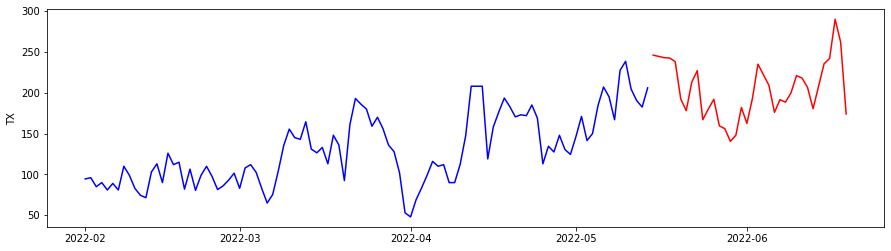

In [ ]:
plt.figure(figsize=(15,4))
sns.lineplot(data = all_future_graph['TX']['2022-02-01':], color = 'r')
sns.lineplot(data = all['TX']['2022-02-01':], color = 'b')

#Residual Check

Sales Performance Residuals 

In [ ]:
# # fit simple linear regression model
# linear_model = ols('SumofSales_O ~ SumofSales_FO',
#                    data=online1).fit()
  
# # display model summary
# print(linear_model.summary())
  
# # modify figure size
# fig = plt.figure(figsize=(14, 8))
  
# # creating regression plots
# fig = sm.graphics.plot_regress_exog(linear_model,
#                                     'SumofSales_FO',
#                                     fig=fig)

# Correlation

In [ ]:
all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 865 entries, 2020-01-01 to 2022-05-14
Freq: D
Data columns (total 96 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Demand(y)                             865 non-null    float64
 1   Drenthe_Ave_Retail_Rec_%Change        820 non-null    float64
 2   Drenthe_Ave_Park_%Change              820 non-null    float64
 3   Drenthe_Std_Retail_Rec_%Change        820 non-null    float64
 4   Drenthe_Std_Park_%Change              820 non-null    float64
 5   Drenthe_Mid_Retail_Rec_%Change        820 non-null    float64
 6   Drenthe_Mid_Park_%Change              820 non-null    float64
 7   Groningen_Mid_Retail_Rec_%Change      820 non-null    float64
 8   Groningen_Mid_Park_%Change            820 non-null    float64
 9   Groningen_Ave_Retail_Rec_%Change      820 non-null    float64
 10  Groningen_Ave_Park_%Change            820 non-null    float

In [ ]:
pd.set_option('display.max_columns', None)

all.corr()

Demand(y)  Drenthe_Ave_Retail_Rec_%Change  \
Demand(y)                        1.000000                       -0.142507   
Drenthe_Ave_Retail_Rec_%Change  -0.142507                        1.000000   
Drenthe_Ave_Park_%Change        -0.011970                        0.640427   
Drenthe_Std_Retail_Rec_%Change  -0.278955                        0.483811   
Drenthe_Std_Park_%Change        -0.185089                        0.548971   
...                                   ...                             ...   
Sat                             -0.256992                       -0.096470   
Sun                             -0.558179                       -0.076560   
stringency_index                 0.340855                       -0.694372   
new_cases_smoothed              -0.025302                       -0.075738   
new_deaths_smoothed              0.181800                       -0.677892   

                                Drenthe_Ave_Park_%Change  \
Demand(y)                                      -0.011970   
Drenthe_Ave_Retail_Rec_%Change                  0.640427   
Drenthe_Ave_Park_%Change                        1.000000   
Drenthe_Std_Retail_Rec_%Change                  0.567663   
Drenthe_Std_Park_%Change                        0.717402   
...                                                  ...   
Sat                                            -0.084193   
Sun                                            -0.160539   
stringency_index                               -0.288805   
new_cases_smoothed                             -0.255041   
new_deaths_smoothed                            -0.453374   

                                Drenthe_Std_Retail_Rec_%Change  \
Demand(y)                                            -0.278955   
Drenthe_Ave_Retail_Rec_%Change                        0.483811   
Drenthe_Ave_Park_%Change                              0.567663   
Drenthe_Std_Retail_Rec_%Change                        1.000000   
Drenthe_Std_Park_%Change                              0.504405   
...                                                        ...   
Sat                                                   0.256510   
Sun                                                   0.060454   
stringency_index                                     -0.324348   
new_cases_smoothed                                   -0.102805   
new_deaths_smoothed                                  -0.380988   

                                Drenthe_Std_Park_%Change  \
Demand(y)                                      -0.185089   
Drenthe_Ave_Retail_Rec_%Change                  0.548971   
Drenthe_Ave_Park_%Change                        0.717402   
Drenthe_Std_Retail_Rec_%Change                  0.504405   
Drenthe_Std_Park_%Change                        1.000000   
...                                                  ...   
Sat                                            -0.007488   
Sun                                             0.014342   
stringency_index                               -0.258192   
new_cases_smoothed                             -0.260025   
new_deaths_smoothed                            -0.444242   

                                Drenthe_Mid_Retail_Rec_%Change  \
Demand(y)                                            -0.121104   
Drenthe_Ave_Retail_Rec_%Change                        0.994780   
Drenthe_Ave_Park_%Change                              0.634761   
Drenthe_Std_Retail_Rec_%Change                        0.450628   
Drenthe_Std_Park_%Change                              0.544874   
...                                                        ...   
Sat                                                  -0.117767   
Sun                                                  -0.085116   
stringency_index                                     -0.690039   
new_cases_smoothed                                   -0.079551   
new_deaths_smoothed                                  -0.665509   

                                Drenthe_Mid_Park_%Change  \
Demand(y)          

In [ ]:
pd.set_option('display.max_rows', None)
correlation = all[all.columns[0:]].corr()['Demand(y)'][:-1].round(3).abs().sort_values(ascending=False)
correlation

Demand(y)                               1.000
Sun                                     0.558
Overijssel_Std_Retail_Rec_%Change       0.366
Groningen_Std_Park_%Change              0.359
Flevoland_Std_Retail_Rec_%Change        0.359
Utrecht_Std_Park_%Change                0.342
stringency_index                        0.341
Limburg_Std_Retail_Rec_%Change          0.319
Gelderland_Std_Retail_Rec_%Change       0.310
Flevoland_Std_Park_%Change              0.306
Zeeland_Std_Retail_Rec_%Change          0.301
Friesland_Std_Retail_Rec_%Change        0.287
Drenthe_Std_Retail_Rec_%Change          0.279
Mon                                     0.271
Sat                                     0.257
North Holland_Std_Retail_Rec_%Change    0.253
Limburg_Std_Park_%Change                0.234
North Holland_Std_Park_%Change          0.231
Groningen_Std_Retail_Rec_%Change        0.223
Friesland_Ave_Park_%Change              0.220
Overijssel_Std_Park_%Change             0.216
Friesland_Std_Park_%Change        

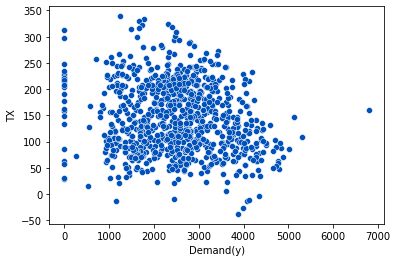

In [ ]:
sns.scatterplot(data=all, x="Demand(y)", y="TX", color = '#0051BA')

#Stationarity

In [ ]:
stationarity = adfuller(all['Demand(y)'])
print('Augmented Dickey Fuller p-value: %F' %stationarity[1])

Augmented Dickey Fuller p-value: 0.240520


In [ ]:
Augmented_Dickey_Fuller_Test_func(all['Demand(y)'],'Demand(y)')

Results of Dickey-Fuller Test for column: Demand(y)
Test Statistic                  -2.109982
p-value                          0.240520
No Lags Used                    21.000000
Number of Observations Used    843.000000
Critical Value (1%)             -3.438131
Critical Value (5%)             -2.864975
Critical Value (10%)            -2.568599
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


# Data Distribution Check

QQ plot (quantile-quantile plot)
* Is this data normally distributed? 
 * normal quantiles vs uniform quantiles to find better fit


* Goodness of fit to a distribution: The Chi-squared test can be used to determine whether your data obeys a known theoretical probability distribution such as the Normal or Poisson distribution.

* Goodness of fit of a regression model: The Chi-squared test can be used to measure the goodness-of-fit of your trained regression model on the training, validation, or test data sets.

* Minimum Chi-squared estimation: For data sets that obey parametric distributions such as the Normal, Poisson or Binomial distributions, the the Chi-squared test can be used to find the parameter range over which the observed values will obey the theoretical distribution.

* Test for independence: The Chi-squared test can be used to test whether two categorical random variables such as Age and Income whose values have been measured in an experiment, are independent of each other.


In [ ]:
# QQ plot import
#from scipy.stats import chisquare
from scipy.special import ndtri

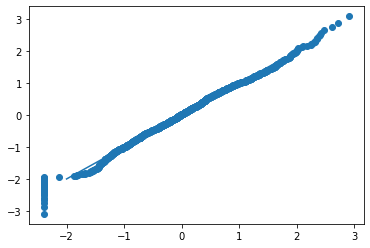

In [ ]:
dist_check = volume_ground.sort_values(by=['Demand(y)'], ascending = True).reset_index()
#Divide the standard normal distribution that is the theoritical distribution into n+1 = n
dist_check['count'] = dist_check.index+1
n_rows = dist_check.shape[0]
dist_check['percentile_area'] = (dist_check['count'])/n_rows
dist_check['z_theoritical'] = ndtri(dist_check['percentile_area'])
dist_check['z_actual']  = (dist_check['Demand(y)'] - dist_check['Demand(y)'].mean())/dist_check['Demand(y)'].std(ddof = 0)

plt.scatter(dist_check.z_actual, dist_check.z_theoritical)
plt.plot([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])
plt.show()

In [ ]:
dist_check.loc[(dist_check['z_actual'] < -2.3)]

Date  Demand(y)  count  percentile_area  z_theoritical  z_actual
0  2020-07-26        0.0      1         0.000985      -3.094651 -2.389428
1  2020-01-01        0.0      2         0.001970      -2.882855 -2.389428
2  2020-04-12        0.0      3         0.002956      -2.752660 -2.389428
3  2020-05-24        0.0      4         0.003941      -2.657093 -2.389428
4  2020-05-31        0.0      5         0.004926      -2.580973 -2.389428
5  2020-06-07        0.0      6         0.005911      -2.517394 -2.389428
6  2020-06-14        0.0      7         0.006897      -2.462607 -2.389428
7  2020-06-21        0.0      8         0.007882      -2.414345 -2.389428
8  2020-06-28        0.0      9         0.008867      -2.371126 -2.389428
9  2020-07-05        0.0     10         0.009852      -2.331929 -2.389428
10 2020-07-12        0.0     11         0.010837      -2.296018 -2.389428
11 2019-12-25        0.0     12         0.011823      -2.262844 -2.389428
12 2020-08-02        0.0     13         0.012808      -2.231988 -2.389428
13 2020-07-19        0.0     14         0.013793      -2.203121 -2.389428
14 2020-08-16        0.0     15         0.014778      -2.175981 -2.389428
15 2021-05-23        0.0     16         0.015764      -2.150356 -2.389428
16 2021-04-04        0.0     17         0.016749      -2.126069 -2.389428
17 2021-12-25        0.0     18         0.017734      -2.102975 -2.389428
18 2020-08-09        0.0     19         0.018719      -2.080951 -2.389428
19 2022-01-01        0.0     20         0.019704      -2.059892 -2.389428
20 2020-12-25        0.0     21         0.020690      -2.039709 -2.389428
21 2022-04-17        0.0     22         0.021675      -2.020324 -2.389428
22 2020-08-30        0.0     23         0.022660      -2.001670 -2.389428
23 2020-08-23        0.0     24         0.023645      -1.983688 -2.389428
24 2021-01-01        0.0     25         0.024631      -1.966325 -2.389428
25 2022-06-05        0.0     26         0.025616      -1.949535 -2.389428

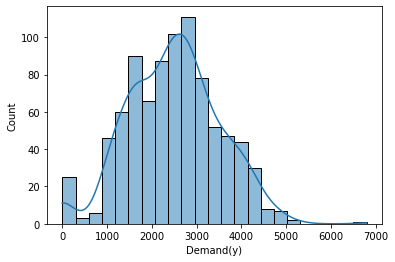

In [ ]:
# Histogram of data distribution
sns.histplot(data = all, x ='Demand(y)', kde = True)
plt.show()

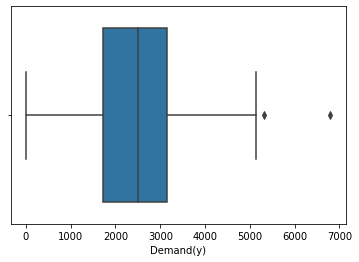

In [ ]:
sns.boxplot(data = all, x ='Demand(y)')

Actual and theoritical distribution check. Not all points fall on the y=x line. So the data isn't completely distributed.

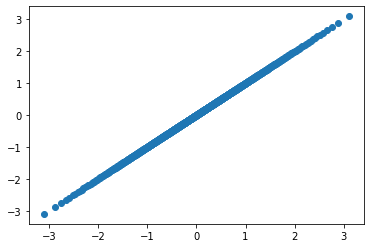

In [ ]:
# This is how it should look like.
plt.scatter(dist_check.z_theoritical, dist_check.z_theoritical)
plt.plot([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

**Hypothesis**\
Note that the mean of volume is 2463 while the variance is 1038276. They are very off from each other. 

There is a over-dispersion and it is not enough to rule out the possibility that volume of call might be Poisson distributed with a theoretical mean rate of 2463.

So two hypotheses were established:\
H0: volume follows a Poisson distribution with a mean of 2463.\
H1: H0 is false. Volume of call is not Poisson distributed.

**Procedure**\
The process to prove (or disprove) H0 using the Chi-squared goodness of fit test. To do so, the following procedure is going to be conducted:



1.   Define the two Hypotheses *completed.
2.   Compute the observed frequencies O_i for each value of the y=volume variable.
3.   Assuming a Poisson distributed y, calculate the expected frequencies E_i for each value of y=volume.
4.   Calculate the test statistic that we have presented above .
5.   Look up the p-value of the test statistic in the Chi-square table. If the p-value is less than 0.05, reject H0 at a 95% confidence level, else accept H0 (i.e. volume are Poisson distributed) at the same confidence level.

In [ ]:
stats_labels = ['Mean Demand(y)', 'Variance Demand(y)', 'Minimum Demand(y)', 'Maximum Demand(y)']
stats_values = [round(all['Demand(y)'].mean(), 2), round(all['Demand(y)'].var(), 2), all['Demand(y)'].min(), all['Demand(y)'].max()]
print('Statistical Summary of Dependent Variable (y)')
print(set(zip(stats_labels, stats_values)))

Statistical Summary of Dependent Variable (y)
{('Mean Demand(y)', 2488.2), ('Variance Demand(y)', 1052037.0), ('Maximum Demand(y)', 6796.0), ('Minimum Demand(y)', 0.0)}


In [ ]:
# 2. To calculate the observed frequencies O_i, create a grouped data set, grouping by frequency of volumne.
grouped_all = all.groupby('Demand(y)').count().sort_values(by='Demand(y)')
# grouped_all = grouped_all.drop([11,24])
grouped_all['Volume_OBS_FREQ'] = grouped_all['Sun']
grouped_all.at[3, 'Volume_OBS_FREQ'] = 3

grouped_all['Volume_OBS_PROBA'] = grouped_all['Volume_OBS_FREQ']/len(all)

The frequencies for volume >= 5 are very less. The Chi-squared test is not accurate for bins with very small frequencies. To get around this issue, summing up frequencies for all volume >= 5 and associate that number with volume=5. Then, also drop the rows for volume > 5 since volume=5 captures frequencies for all volume >=5.

#**Phase 2: Testing Models**

In this section, Prophet, Prophet+XGB, and Ensembled models are applied for the forecasting. 
1. Apply the organized data into models
2. Run the models
3. Get the assessment scores


# Prep: "Dataset" and "Holidays"

In [ ]:
# bring the date index into column
dataset = all.reset_index()
dataset['Date'] = dataset["index"].dt.strftime('%Y-%m-%d')
# data = data.drop(['index'], axis =1)

In [ ]:
# Data Transformation
dataset.Date = pd.to_datetime(dataset.Date, format = '%Y-%m-%d')
dataset.Date 

0     2020-01-01
1     2020-01-02
2     2020-01-03
3     2020-01-04
4     2020-01-05
5     2020-01-06
6     2020-01-07
7     2020-01-08
8     2020-01-09
9     2020-01-10
10    2020-01-11
11    2020-01-12
12    2020-01-13
13    2020-01-14
14    2020-01-15
15    2020-01-16
16    2020-01-17
17    2020-01-18
18    2020-01-19
19    2020-01-20
20    2020-01-21
21    2020-01-22
22    2020-01-23
23    2020-01-24
24    2020-01-25
25    2020-01-26
26    2020-01-27
27    2020-01-28
28    2020-01-29
29    2020-01-30
30    2020-01-31
31    2020-02-01
32    2020-02-02
33    2020-02-03
34    2020-02-04
35    2020-02-05
36    2020-02-06
37    2020-02-07
38    2020-02-08
39    2020-02-09
40    2020-02-10
41    2020-02-11
42    2020-02-12
43    2020-02-13
44    2020-02-14
45    2020-02-15
46    2020-02-16
47    2020-02-17
48    2020-02-18
49    2020-02-19
50    2020-02-20
51    2020-02-21
52    2020-02-22
53    2020-02-23
54    2020-02-24
55    2020-02-25
56    2020-02-26
57    2020-02-27
58    2020-02-

In [ ]:
# Due to the requirement of FBProphet, rename y column and datastamp variables
dataset = dataset.rename(columns= {'Demand(y)':'y'})
dataset = dataset.rename(columns= {'Date':'ds'})


In [ ]:
#Holidays
"""""""""""""""""""""""""""""""""""""""
Store holiday dates from the Holidays column
---------------------------------------
In case of Facebook Prophet, holiday data could be simpler as it couls set up
the date range to consider as holidays.
However, it can't specify more details of holiday range. For example, christmas 
holidays can last two weeks while black friday or other national holidays can be less.

If I would like to specify each of the holidays range differently, I would need 
to create each one of these per holiday 
"""""""""""""""""""""""""""""""""""""""
holiday_dates = dataset[dataset.Holidays == 1].ds
holidays = pd.DataFrame({'holiday': 'holi', 
                         'ds':pd.to_datetime(holiday_dates),
                         #'lower_window':0, #3 days prior to the holiday that was counted
                         #'upper_window':0  
                         #1 day after to the holiday that was counted
})                       #upper and lower can be 0 as they are manually specified
holidays.head()

holiday         ds
0    holi 2020-01-01
1    holi 2020-01-02
2    holi 2020-01-03
3    holi 2020-01-04
4    holi 2020-01-05

In [ ]:
#remove Holidays columns from dataset as the holidays are created seperately.
dataset = dataset.drop(columns = "Holidays")
dataset = dataset.fillna(0)
dataset.head(2)


index       y  Drenthe_Ave_Retail_Rec_%Change  \
0 2020-01-01     0.0                             0.0   
1 2020-01-02  2288.0                             0.0   

   Drenthe_Ave_Park_%Change  Drenthe_Std_Retail_Rec_%Change  \
0                       0.0                             0.0   
1                       0.0                             0.0   

   Drenthe_Std_Park_%Change  Drenthe_Mid_Retail_Rec_%Change  \
0                       0.0                             0.0   
1                       0.0                             0.0   

   Drenthe_Mid_Park_%Change  Groningen_Mid_Retail_Rec_%Change  \
0                       0.0                               0.0   
1                       0.0                               0.0   

   Groningen_Mid_Park_%Change  Groningen_Ave_Retail_Rec_%Change  \
0                         0.0                               0.0   
1                         0.0                               0.0   

   Groningen_Ave_Park_%Change  Groningen_Std_Retail_Rec_%Change  \
0                         0.0                               0.0   
1                         0.0                               0.0   

   Groningen_Std_Park_%Change  Zeeland_Std_Retail_Rec_%Change  \
0                         0.0                             0.0   
1                         0.0                             0.0   

   Zeeland_Std_Park_%Change  Zeeland_Mid_Retail_Rec_%Change  \
0                       0.0                             0.0   
1                       0.0                             0.0   

   Zeeland_Mid_Park_%Change  Zeeland_Ave_Retail_Rec_%Change  \
0                       0.0                             0.0   
1                       0.0                             0.0   

   Zeeland_Ave_Park_%Change  Flevoland_Ave_Retail_Rec_%Change  \
0                       0.0                               0.0   
1                       0.0                               0.0   

   Flevoland_Ave_Park_%Change  Flevoland_Mid_Retail_Rec_%Change  \
0                         0.0                               0.0   
1                         0.0                               0.0   

   Flevoland_Mid_Park_%Change  Flevoland_Std_Retail_Rec_%Change  \
0                         0.0                               0.0   
1                         0.0                               0.0   

   Flevoland_Std_Park_%Change  South Holland_Std_Retail_Rec_%Change  \
0                         0.0                                   0.0   
1                         0.0                                   0.0   

   South Holland_Std_Park_%Change  South Holland_Ave_Retail_Rec_%Change  \
0                             0.0                                   0.0   
1                             0.0                                   0.0   

   South Holland_Ave_Park_%Change  South Holland_Mid_Retail_Rec_%Change  \
0                             0.0                                   0.0   
1                             0.0                                   0.0   

   South Holland_Mid_Park_%Change  North Brabant_Ave_Retail_Rec_%Change  \
0                             0.0                                   0.0   
1                             0.0                                   0.0   

   North Brabant_Ave_Park_%Change  North Brabant_Std_Retail_Rec_%Change  \
0                             0.0                                   0.0   
1                             0.0                                   0.0   

   North Brabant_Std_Park_%Change  North Brabant_Mid_Retail_Rec_%Change  \
0                             0.0                                   0.0   
1                             0.0                                   0.0   

   North Brabant_Mid_Park_%Change  Friesland_Std_Retail_Rec_%Change  \
0                             0.0                               0.0   
1                             0.0                               0.0   

   Friesland_Std_Park_%Change  Friesland_Mid_Retail_Rec_%Change  \
0                         0.0                            

In [ ]:
test_set = dataset.iloc[-test_days:, :]
actual_value = test_set['y']

In [ ]:
actual_value

830     876.0
831    2801.0
832    2136.0
833    2341.0
834    1872.0
835    1865.0
836    1214.0
837       0.0
838     889.0
839    2281.0
840    2347.0
841    1999.0
842    2146.0
843    1355.0
844     845.0
845    2703.0
846    2188.0
847     554.0
848    2260.0
849    2199.0
850    1387.0
851     803.0
852    2749.0
853    1754.0
854    2135.0
855    2045.0
856    1731.0
857    1217.0
858     576.0
859    2012.0
860    1938.0
861    1700.0
862    1729.0
863    1782.0
864    1058.0
Name: y, dtype: float64

# Model 1: Prophet



**Benefit of Prophet Model**\
(+) dynamic holidays; it allows us to further dig and study about holidays\
(+) customizable and intuitive for non-experts; built-in cross validation and hyperparameter tuning\


**Methodological framework**\
y(t) = c(t)+s(t)+h(t)+x(t)+e

where c(t) = trent, s(t) = seasonality, and h(t) = holiday effects, x(t) = external variables/regressors, and e = error

In [ ]:
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 5)

In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Seperating the dataset into Training and Testing
"""""""""""""""""""""""""""""""""""""""""""""""""""
prophet_training_set = dataset.iloc[:-test_days, :]
prophet_test_set = dataset.iloc[-test_days:, :]
prophet_test_set

index       y  Drenthe_Ave_Retail_Rec_%Change  \
830 2022-04-10   876.0                        3.333333   
831 2022-04-11  2801.0                       -0.500000   
..         ...     ...                             ...   
863 2022-05-13  1782.0                       -3.125000   
864 2022-05-14  1058.0                        5.200000   

     Drenthe_Ave_Park_%Change  Drenthe_Std_Retail_Rec_%Change  \
830                 38.428571                        4.760952   
831                103.000000                        7.063993   
..                        ...                             ...   
863                 86.400000                        7.605214   
864                101.333333                       17.370473   

     Drenthe_Std_Park_%Change  Drenthe_Mid_Retail_Rec_%Change  ...  Fri  Sat  \
830                 27.214317                             3.5  ...  0.0  0.0   
831                 27.214317                             1.5  ...  0.0  0.0   
..                        ...                             ...  ...  ...  ...   
863                 22.667157                            -2.5  ...  1.0  0.0   
864                 61.158265                             1.0  ...  0.0  1.0   

     Sun  stringency_index  new_cases_smoothed  new_deaths_smoothed         ds  
830  1.0             23.15           11241.857               12.143 2022-04-10  
831  0.0             23.15           10650.857               11.143 2022-04-11  
..   ...               ...                 ...                  ...        ...  
863  0.0             19.44            1353.429                3.143 2022-05-13  
864  0.0             19.44            1331.286                2.857 2022-05-14  

[35 rows x 97 columns]

In [ ]:
#check
stats_labels = ['Mean Demand(y)', 'Variance Demand(y)', 'Minimum Demand(y)', 'Maximum Demand(y)']
stats_values = [round(prophet_training_set['y'].mean(), 2), round(prophet_training_set['y'].var(), 2), prophet_training_set['y'].min(), prophet_training_set['y'].max()]
print('Statistical Summary of Training Dependent Variable (y)')
print(set(zip(stats_labels, stats_values)))

#check
stats_labels = ['Mean Demand(y)', 'Variance Demand(y)', 'Minimum Demand(y)', 'Maximum Demand(y)']
stats_values = [round(prophet_test_set['y'].mean(), 2), round(prophet_test_set['y'].var(), 2), prophet_test_set['y'].min(), prophet_test_set['y'].max()]
print('Statistical Summary of Test Dependent Variable (y)')
print(set(zip(stats_labels, stats_values)))

Statistical Summary of Training Dependent Variable (y)
{('Maximum Demand(y)', 6796.0), ('Mean Demand(y)', 2521.45), ('Variance Demand(y)', 1050114.48), ('Minimum Demand(y)', 0.0)}
Statistical Summary of Test Dependent Variable (y)
{('Maximum Demand(y)', 2801.0), ('Variance Demand(y)', 462734.42), ('Mean Demand(y)', 1699.63), ('Minimum Demand(y)', 0.0)}


**Facebook Prophet Component Descriptions**


*   **Growth** : Linear / Logistic ; how does the trend shape like?
*   **Holidays**: use the one prepared already above
*   **Seasonality**: yearly, weekly, daily
*   **Seasonality_mode**: multiplicative or additive
*   **Seasonality_Prior_scale**: strength of the seasonality (continous number). higher number means stronger seasonality
*   **Holiday_Prior_scale**: strength of the holiday (continous number)
*   **Changepoint_prior_scale**: flexibility of the automatic changepoint selection: how to detect the changes in trend and whether it should detect changes in trend easily or more robust




In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Facebook Prophet Model
"""""""""""""""""""""""""""""""""""""""""""""""""""
m = Prophet(growth = 'linear',
            yearly_seasonality=True, #Jan to Feb etc
            weekly_seasonality=True, #monday to sunday seasonality
            daily_seasonality= True, #if data is daily, then True
            holidays = holidays, #it was already defined earlier
            seasonality_mode ='additive', #use additive seasonality during the pandemic so that it’s not biased by 2020’s abnormal baseline, especially when COVID greatly impacts your time series data.
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05 #this is more to leave it to the model and reflect how easy it is to have a break of trends
            )

m.add_regressor('DDVEC')
m.add_regressor('FHVEC')
m.add_regressor('FG')
m.add_regressor('FXX')
m.add_regressor('TG')
m.add_regressor('TN')
m.add_regressor('TX')
m.add_regressor('SQ')
m.add_regressor('NG')
m.add_regressor('RH')
m.add_regressor('christmas_NY')
m.add_regressor('easter_whit')
m.add_regressor('Mon')
m.add_regressor('Tue')
m.add_regressor('Wed')
m.add_regressor('Thu')
m.add_regressor('Fri')
m.add_regressor('Sat')
m.add_regressor('Sun')
m.add_regressor('stringency_index')
m.add_regressor('new_cases_smoothed')
m.add_regressor('new_deaths_smoothed')
m.add_regressor('Drenthe_Ave_Retail_Rec_%Change')
m.add_regressor('Drenthe_Ave_Park_%Change')
m.add_regressor('Drenthe_Std_Retail_Rec_%Change')
m.add_regressor('Drenthe_Std_Park_%Change')
m.add_regressor('Drenthe_Mid_Retail_Rec_%Change')
m.add_regressor('Drenthe_Mid_Park_%Change')
m.add_regressor('Groningen_Mid_Retail_Rec_%Change')
m.add_regressor('Groningen_Mid_Park_%Change')
m.add_regressor('Groningen_Ave_Retail_Rec_%Change')
m.add_regressor('Groningen_Ave_Park_%Change')
m.add_regressor('Groningen_Std_Retail_Rec_%Change')
m.add_regressor('Groningen_Std_Park_%Change')
m.add_regressor('Zeeland_Std_Retail_Rec_%Change')
m.add_regressor('Zeeland_Std_Park_%Change')
m.add_regressor('Zeeland_Mid_Retail_Rec_%Change')
m.add_regressor('Zeeland_Mid_Park_%Change')
m.add_regressor('Zeeland_Ave_Retail_Rec_%Change')
m.add_regressor('Zeeland_Ave_Park_%Change')
m.add_regressor('Flevoland_Ave_Retail_Rec_%Change')
m.add_regressor('Flevoland_Ave_Park_%Change')
m.add_regressor('Flevoland_Mid_Retail_Rec_%Change')
m.add_regressor('Flevoland_Mid_Park_%Change')
m.add_regressor('Flevoland_Std_Retail_Rec_%Change')
m.add_regressor('Flevoland_Std_Park_%Change')
m.add_regressor('South Holland_Std_Retail_Rec_%Change')
m.add_regressor('South Holland_Std_Park_%Change')
m.add_regressor('South Holland_Ave_Retail_Rec_%Change')
m.add_regressor('South Holland_Ave_Park_%Change')
m.add_regressor('South Holland_Mid_Retail_Rec_%Change')
m.add_regressor('South Holland_Mid_Park_%Change')
m.add_regressor('North Brabant_Ave_Retail_Rec_%Change')
m.add_regressor('North Brabant_Ave_Park_%Change')
m.add_regressor('North Brabant_Std_Retail_Rec_%Change')
m.add_regressor('North Brabant_Std_Park_%Change')
m.add_regressor('North Brabant_Mid_Retail_Rec_%Change')
m.add_regressor('North Brabant_Mid_Park_%Change')
m.add_regressor('Friesland_Std_Retail_Rec_%Change')
m.add_regressor('Friesland_Std_Park_%Change')
m.add_regressor('Friesland_Mid_Retail_Rec_%Change')
m.add_regressor('Friesland_Mid_Park_%Change')
m.add_regressor('Friesland_Ave_Retail_Rec_%Change')
m.add_regressor('Friesland_Ave_Park_%Change')
m.add_regressor('Gelderland_Mid_Retail_Rec_%Change')
m.add_regressor('Gelderland_Mid_Park_%Change')
m.add_regressor('Gelderland_Ave_Retail_Rec_%Change')
m.add_regressor('Gelderland_Ave_Park_%Change')
m.add_regressor('Gelderland_Std_Retail_Rec_%Change')
m.add_regressor('Gelderland_Std_Park_%Change')
m.add_regressor('Utrecht_Ave_Retail_Rec_%Change')
m.add_regressor('Utrecht_Ave_Park_%Change')
m.add_regressor('Utrecht_Mid_Retail_Rec_%Change')
m.add_regressor('Utrecht_Mid_Park_%Change')
m.add_regressor('Utrecht_Std_Retail_Rec_%Change')
m.add_regressor('Utrecht_Std_Park_%Change')
m.add_regressor('Limburg_Mid_Retail_Rec_%Change')
m.add_regressor('Limburg_Mid_Park_%Change')
m.add_regressor('Limburg_Std_Retail_Rec_%Change')
m.add_regressor('Limburg_Std_Park_%Change')
m.add_regressor('Limburg_Ave_Retail_Rec_%Change')
m.add_regressor('Limburg_Ave_Park_%Change')
m.add_regressor('North Holland_Std_Retail_Rec_%Change')
m.add_regressor('North Holland_Std_Park_%Change')
m.add_regressor('North Holland_Mid_Retail_Rec_%Change')
m.add_regressor('North Holland_Mid_Park_%Change')
m.add_regressor('North Holland_Ave_Retail_Rec_%Change')
m.add_regressor('North Holland_Ave_Park_%Change')
m.add_regressor('Overijssel_Std_Retail_Rec_%Change')
m.add_regressor('Overijssel_Std_Park_%Change')
m.add_regressor('Overijssel_Ave_Retail_Rec_%Change')
m.add_regressor('Overijssel_Ave_Park_%Change')
m.add_regressor('Overijssel_Mid_Retail_Rec_%Change')
m.add_regressor('Overijssel_Mid_Park_%Change')




m.fit(prophet_training_set)

In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Forecasting
"""""""""""""""""""""""""""""""""""""""""""""""""""
# Create Future Dataframe
future = m.make_future_dataframe(periods = len(prophet_test_set),
                                 freq = "D")
future.tail(1)

ds
864 2022-05-14

In [ ]:
# merge regressors
future = pd.concat([future, dataset.iloc[:, 1:-1]], # do not include "ds" and 'y' columns
                    axis = 1)


In [ ]:
future

ds       y  Drenthe_Ave_Retail_Rec_%Change  \
0   2020-01-01     0.0                           0.000   
1   2020-01-02  2288.0                           0.000   
..         ...     ...                             ...   
863 2022-05-13  1782.0                          -3.125   
864 2022-05-14  1058.0                           5.200   

     Drenthe_Ave_Park_%Change  Drenthe_Std_Retail_Rec_%Change  \
0                    0.000000                        0.000000   
1                    0.000000                        0.000000   
..                        ...                             ...   
863                 86.400000                        7.605214   
864                101.333333                       17.370473   

     Drenthe_Std_Park_%Change  Drenthe_Mid_Retail_Rec_%Change  ...  Thu  Fri  \
0                    0.000000                             0.0  ...  0.0  0.0   
1                    0.000000                             0.0  ...  1.0  0.0   
..                        ...                             ...  ...  ...  ...   
863                 22.667157                            -2.5  ...  0.0  1.0   
864                 61.158265                             1.0  ...  0.0  0.0   

     Sat  Sun  stringency_index  new_cases_smoothed  new_deaths_smoothed  
0    0.0  0.0              0.00               0.000                0.000  
1    0.0  0.0              0.00               0.000                0.000  
..   ...  ...               ...                 ...                  ...  
863  0.0  0.0             19.44            1353.429                3.143  
864  1.0  0.0             19.44            1331.286                2.857  

[865 rows x 96 columns]

In [ ]:
#Forecasting
forecast = m.predict(future)
forecast.columns.to_list()

['ds',
 'trend',
 'yhat_lower',
 'yhat_upper',
 'trend_lower',
 'trend_upper',
 'DDVEC',
 'DDVEC_lower',
 'DDVEC_upper',
 'Drenthe_Ave_Park_%Change',
 'Drenthe_Ave_Park_%Change_lower',
 'Drenthe_Ave_Park_%Change_upper',
 'Drenthe_Ave_Retail_Rec_%Change',
 'Drenthe_Ave_Retail_Rec_%Change_lower',
 'Drenthe_Ave_Retail_Rec_%Change_upper',
 'Drenthe_Mid_Park_%Change',
 'Drenthe_Mid_Park_%Change_lower',
 'Drenthe_Mid_Park_%Change_upper',
 'Drenthe_Mid_Retail_Rec_%Change',
 'Drenthe_Mid_Retail_Rec_%Change_lower',
 'Drenthe_Mid_Retail_Rec_%Change_upper',
 'Drenthe_Std_Park_%Change',
 'Drenthe_Std_Park_%Change_lower',
 'Drenthe_Std_Park_%Change_upper',
 'Drenthe_Std_Retail_Rec_%Change',
 'Drenthe_Std_Retail_Rec_%Change_lower',
 'Drenthe_Std_Retail_Rec_%Change_upper',
 'FG',
 'FG_lower',
 'FG_upper',
 'FHVEC',
 'FHVEC_lower',
 'FHVEC_upper',
 'FXX',
 'FXX_lower',
 'FXX_upper',
 'Flevoland_Ave_Park_%Change',
 'Flevoland_Ave_Park_%Change_lower',
 'Flevoland_Ave_Park_%Change_upper',
 'Flevoland_Ave

In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Prediction
"""""""""""""""""""""""""""""""""""""""""""""""""""
predictions_prophet = forecast.yhat[-test_days:].rename('prophet')
predictions_prophet[:5]

830    1243.595657
831    2838.755309
832    2704.395085
833    2941.110241
834    2730.853176
Name: prophet, dtype: float64

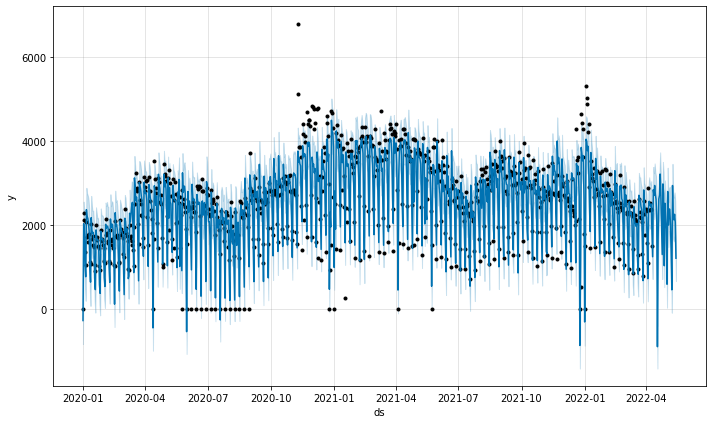

In [ ]:
# Visualization
m.plot(forecast);

Blue line is the actual result, while blue means the result of forecast

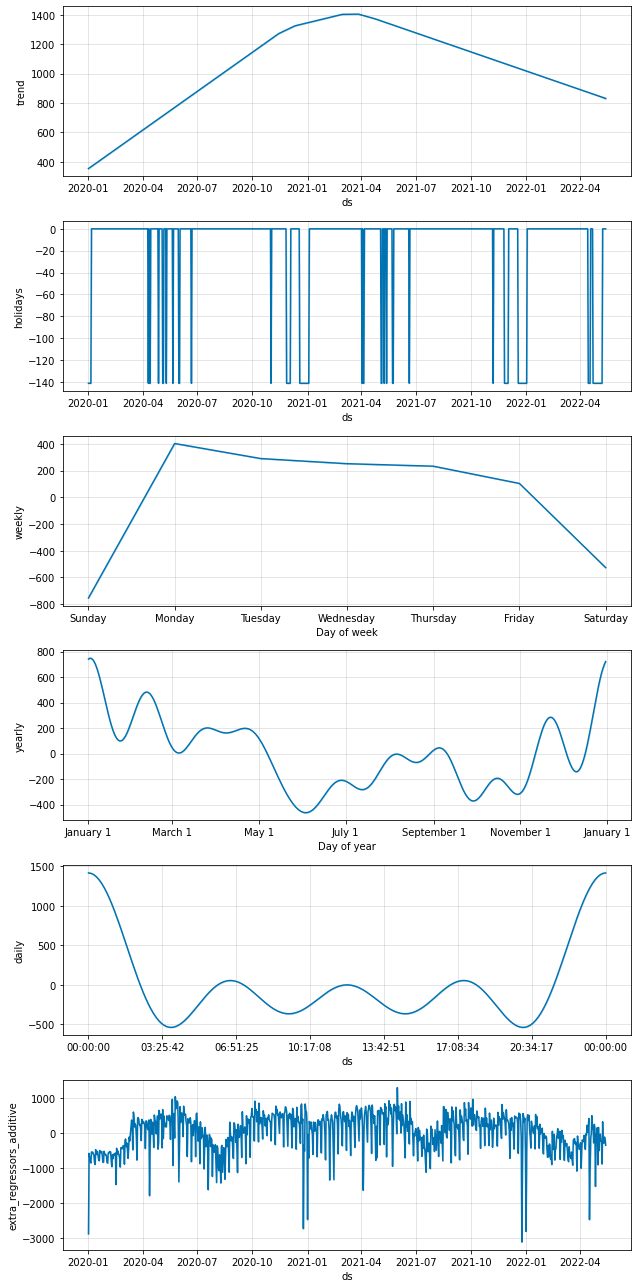

In [ ]:
#plot components
m.plot_components(forecast);

Interpretation of the components:


*   Trend: annual trend. July is the peak season
*   Holiday: the positive part means that that day of holidays are giving more calls to CSC while negative means opposite
*   Week: Monday and Tuesday seems to haave more higher demand of call compared to the weekends
*   Yearly: doesn't seem to have really strong seasonality defined. March has higher demands than Feburary for example. Since the data contains 2.5 years, so it may not be enough to define the seasonality clearly.
*   Regressors: the regressors seem to have more impact on the outcome from 2021 or later.



In [ ]:
predictions_prophet = predictions_prophet.rename('prophet')
predictions_prophet.index = prophet_test_set['ds']
predictions_prophet

ds
2022-04-10    1243.595657
2022-04-11    2838.755309
                 ...     
2022-05-13    2064.025382
2022-05-14    1208.226885
Name: prophet, Length: 35, dtype: float64

Text(0.5, 0, 'Date')

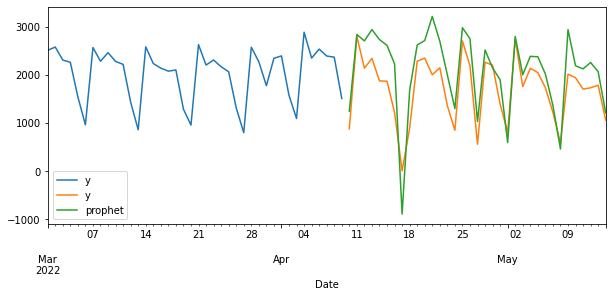

In [ ]:
# Visualization
prophet_training_set.index = prophet_training_set.ds
prophet_test_set.index = prophet_test_set.ds


prophet_training_set.y['2022-03-01':].plot(figsize = (10,4), legend = True)
prophet_test_set.y.plot(legend = True)
predictions_prophet.plot(legend=True)

plt.xlabel('Date')

In [ ]:
actual_value = prophet_test_set['y']

In [ ]:
actual_value

ds
2022-04-10     876.0
2022-04-11    2801.0
               ...  
2022-05-13    1782.0
2022-05-14    1058.0
Name: y, Length: 35, dtype: float64

In [ ]:
timeseries_evaluation_metrics_func(actual_value, predictions_prophet)

Evaluation metric results:-
MSE is : 286615.9756228106
MAE is : 450.57240092142223
RMSE is : 535.3652730826035
MAPE is : inf
R2 is : 0.36238618407756795



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


This means that the function will return -Inf, Inf, or NaN if actual is zero. Due to the instability at or near zero, smape or mase are often used as alternatives.


MAPE doesn't make sense when y_true can be zero, because division by zero is not defined. You'll have to use a different measurement.



# Model 2: Hybrid

This combined model would meet both seasonality and nonlinearity of the dataset.

**Pros of XGBoost**
* XGBoost gives different weights depending on how difficult it is to predict the outcome over testing multiple trees. Thus, it gives greate weight on the predictor that had wrong outcome. This process continues until the model find the optimal wy for each observations.

* Helps preventing overfitting the model by looking at a fraction of the full dataset per tree. Thus, any dataset comes in the future won't be too must or less influenced.

* Weights are also distributed on different predictors per trees (not only on the data). thus, it creates more and more optimized model that sees what is important and slightly ignores predictions that are not as important.

* Treats NA values as information unlike other models

* non-linear relationship between dependent and independent variables


**Cons of XGBoost**
* complex programming
* can need intense optimization


In [ ]:
# Spliting trainig and test set
FBXGB_training_set = dataset.iloc[:-test_days, :]
FBXGB_test_set = dataset.iloc[-test_days:, :]
FBXGB_training_set

index       y  Drenthe_Ave_Retail_Rec_%Change  \
0   2020-01-01     0.0                        0.000000   
1   2020-01-02  2288.0                        0.000000   
..         ...     ...                             ...   
828 2022-04-08  2366.0                       -4.000000   
829 2022-04-09  1507.0                        3.181818   

     Drenthe_Ave_Park_%Change  Drenthe_Std_Retail_Rec_%Change  \
0                    0.000000                        0.000000   
1                    0.000000                        0.000000   
..                        ...                             ...   
828                 33.333333                        6.557439   
829                 32.166667                       19.062099   

     Drenthe_Std_Park_%Change  Drenthe_Mid_Retail_Rec_%Change  ...  Fri  Sat  \
0                    0.000000                             0.0  ...  0.0  0.0   
1                    0.000000                             0.0  ...  0.0  0.0   
..                        ...                             ...  ...  ...  ...   
828                 30.454337                            -3.0  ...  1.0  0.0   
829                 23.455632                            -5.0  ...  0.0  1.0   

     Sun  stringency_index  new_cases_smoothed  new_deaths_smoothed         ds  
0    0.0              0.00               0.000                0.000 2020-01-01  
1    0.0              0.00               0.000                0.000 2020-01-02  
..   ...               ...                 ...                  ...        ...  
828  0.0             23.15           12990.714               12.429 2022-04-08  
829  0.0             23.15           11984.571               12.714 2022-04-09  

[830 rows x 97 columns]

**XGBoost Preparation**

In [ ]:
# forecast is coming from the prophet model. The previous part may be not necessary
prophet_variables = forecast.loc[:, ['trend', 
                                     'weekly',
                                     'holi',
                                     'yearly',
                                     'daily'#choose variables from "forecast" dataframe
]]

In [ ]:
dataset1 =dataset [[

'y', 'ds',

 'Gelderland_Mid_Retail_Rec_%Change', 'Gelderland_Mid_Park_%Change',
 'Gelderland_Std_Retail_Rec_%Change', 'Gelderland_Std_Park_%Change',
 'Gelderland_Ave_Retail_Rec_%Change', 'Gelderland_Ave_Park_%Change', 
 'Limburg_Std_Retail_Rec_%Change', 'Limburg_Std_Park_%Change',
 'Limburg_Mid_Retail_Rec_%Change', 'Limburg_Mid_Park_%Change',
 'Limburg_Ave_Retail_Rec_%Change', 'Limburg_Ave_Park_%Change',
 'North Brabant_Ave_Retail_Rec_%Change', 'North Brabant_Ave_Park_%Change',
 'North Brabant_Mid_Retail_Rec_%Change', 'North Brabant_Mid_Park_%Change',
 'North Brabant_Std_Retail_Rec_%Change', 'North Brabant_Std_Park_%Change',
 'Zeeland_Mid_Retail_Rec_%Change', 'Zeeland_Mid_Park_%Change',
 'Zeeland_Ave_Retail_Rec_%Change', 'Zeeland_Ave_Park_%Change',
 'Zeeland_Std_Retail_Rec_%Change', 'Zeeland_Std_Park_%Change',
 'Overijssel_Ave_Retail_Rec_%Change', 'Overijssel_Ave_Park_%Change',
 'Overijssel_Mid_Retail_Rec_%Change', 'Overijssel_Mid_Park_%Change',
 'Overijssel_Std_Retail_Rec_%Change', 'Overijssel_Std_Park_%Change',
 'North Holland_Mid_Retail_Rec_%Change', 'North Holland_Mid_Park_%Change',
 'North Holland_Ave_Retail_Rec_%Change', 'North Holland_Ave_Park_%Change',
 'North Holland_Std_Retail_Rec_%Change', 'North Holland_Std_Park_%Change',
 'Utrecht_Mid_Retail_Rec_%Change', 'Utrecht_Mid_Park_%Change',
 'Utrecht_Ave_Retail_Rec_%Change', 'Utrecht_Ave_Park_%Change',
 'Utrecht_Std_Retail_Rec_%Change', 'Utrecht_Std_Park_%Change',
 'Flevoland_Ave_Retail_Rec_%Change', 'Flevoland_Ave_Park_%Change',
 'Flevoland_Mid_Retail_Rec_%Change', 'Flevoland_Mid_Park_%Change',
 'Flevoland_Std_Retail_Rec_%Change', 'Flevoland_Std_Park_%Change',
 'South Holland_Mid_Retail_Rec_%Change', 'South Holland_Mid_Park_%Change',
 'South Holland_Std_Retail_Rec_%Change', 'South Holland_Std_Park_%Change',
 'South Holland_Ave_Retail_Rec_%Change', 'South Holland_Ave_Park_%Change',
 'Groningen_Std_Retail_Rec_%Change', 'Groningen_Std_Park_%Change',
 'Groningen_Mid_Retail_Rec_%Change', 'Groningen_Mid_Park_%Change',
 'Groningen_Ave_Retail_Rec_%Change', 'Groningen_Ave_Park_%Change',
 'Friesland_Ave_Retail_Rec_%Change', 'Friesland_Ave_Park_%Change',
 'Friesland_Mid_Retail_Rec_%Change', 'Friesland_Mid_Park_%Change',
 'Friesland_Std_Retail_Rec_%Change', 'Friesland_Std_Park_%Change',
 'Drenthe_Mid_Retail_Rec_%Change', 'Drenthe_Mid_Park_%Change',
 'Drenthe_Ave_Retail_Rec_%Change', 'Drenthe_Ave_Park_%Change',
 'Drenthe_Std_Retail_Rec_%Change', 'Drenthe_Std_Park_%Change',
 'DDVEC', 'FHVEC', 'FG', 'FXX', 'TG', 'TN', 'TX', 'SQ', 'NG', 'RH',
 'christmas_NY', 'easter_whit',
 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun',
 'stringency_index',  'new_cases_smoothed', 'new_deaths_smoothed',

         ]]

In [ ]:
# merge the dataset variables and prphet result
df_xgb = pd.concat([dataset1, prophet_variables], axis = 1) 

In [ ]:
pd.set_option('display.max_rows', None)
df_xgb[df_xgb.columns[0:]].corr()['y'][:-1].round(3).abs().sort_values(ascending=False)

y                                       1.000
weekly                                  0.667
Sun                                     0.558
trend                                   0.432
stringency_index                        0.411
Groningen_Std_Park_%Change              0.295
Overijssel_Std_Retail_Rec_%Change       0.275
Mon                                     0.271
Flevoland_Std_Retail_Rec_%Change        0.264
Sat                                     0.257
Flevoland_Std_Park_%Change              0.234
new_deaths_smoothed                     0.234
Utrecht_Std_Park_%Change                0.224
Gelderland_Std_Park_%Change             0.221
Friesland_Ave_Retail_Rec_%Change        0.216
Zeeland_Std_Retail_Rec_%Change          0.212
Friesland_Mid_Retail_Rec_%Change        0.204
Flevoland_Ave_Retail_Rec_%Change        0.196
easter_whit                             0.195
Friesland_Std_Retail_Rec_%Change        0.191
Overijssel_Ave_Retail_Rec_%Change       0.191
Limburg_Std_Retail_Rec_%Change    

In [ ]:
# Now you can see the seasonality data from Prophet is with the other features
df_xgb

y         ds  Gelderland_Mid_Retail_Rec_%Change  \
0       0.0 2020-01-01                                0.0   
1    2288.0 2020-01-02                                0.0   
2    2129.0 2020-01-03                                0.0   
3    1354.0 2020-01-04                                0.0   
4    1045.0 2020-01-05                                0.0   
5    2063.0 2020-01-06                                0.0   
6    1703.0 2020-01-07                                0.0   
7    1767.0 2020-01-08                                0.0   
8    1590.0 2020-01-09                                0.0   
9    1788.0 2020-01-10                                0.0   
10   1113.0 2020-01-11                                0.0   
11   1065.0 2020-01-12                                0.0   
12   2022.0 2020-01-13                                0.0   
13   1664.0 2020-01-14                                0.0   
14   1739.0 2020-01-15                                0.0   
15   1513.0 2020-01-16                                0.0   
16   1466.0 2020-01-17                                0.0   
17   1055.0 2020-01-18                                0.0   
18    907.0 2020-01-19                                0.0   
19   2006.0 2020-01-20                                0.0   
20   1721.0 2020-01-21                                0.0   
21   1646.0 2020-01-22                                0.0   
22   1503.0 2020-01-23                                0.0   
23   1450.0 2020-01-24                                0.0   
24   1025.0 2020-01-25                                0.0   
25    934.0 2020-01-26                                0.0   
26   1879.0 2020-01-27                                0.0   
27   1628.0 2020-01-28                                0.0   
28   1665.0 2020-01-29                                0.0   
29   1519.0 2020-01-30                                0.0   
30   1444.0 2020-01-31                                0.0   
31   1134.0 2020-02-01                                0.0   
32   1087.0 2020-02-02                                0.0   
33   2141.0 2020-02-03                                0.0   
34   1763.0 2020-02-04                                0.0   
35   1818.0 2020-02-05                                0.0   
36   1625.0 2020-02-06                                0.0   
37   1564.0 2020-02-07                                0.0   
38   1152.0 2020-02-08                                0.0   
39   1104.0 2020-02-09                                0.0   
40   1880.0 2020-02-10                                0.0   
41   1621.0 2020-02-11                                0.0   
42   1676.0 2020-02-12                                0.0   
43   1535.0 2020-02-13                                0.0   
44   1449.0 2020-02-14                                0.0   
45   1058.0 2020-02-15                                2.5   
46   1017.0 2020-02-16                               -5.0   
47   2099.0 2020-02-17                                0.0   
48   1747.0 2020-02-18                                6.0   
49   1762.0 2020-02-19                                4.0   
50   1711.0 2020-02-20                                2.0   
51   1682.0 2020-02-21                                6.0   
52   1098.0 2020-02-22                                1.0   
53   1125.0 2020-02-23                               -2.0   
54   2125.0 2020-02-24                                8.5   
55   1752.0 2020-02-25                               18.0   
56   1897.0 2020-02-26                                7.0   
57   1836.0 2020-02-27                                2.0   
58   1693.0 2020-02-28                                3.0   
59   1297.0 2020-02-29                               -4.0   
60   1232.0 2020-03-01                                4.0   
61   2371.0 2020-03-02                               -7.0   
62   1920.0 2020-03-03                                3.0   
63   1820.0 2020-03-04                                3.0   
64   1735.0 2020-03-05                       

In [ ]:
# Create Training and Testing dataset
FBXGBcombined_training_set = df_xgb.iloc[:-test_days, :]
FBXGBcombined_test_set = df_xgb.iloc[-test_days:, :]
FBXGBcombined_training_set

y         ds  Gelderland_Mid_Retail_Rec_%Change  \
0       0.0 2020-01-01                                0.0   
1    2288.0 2020-01-02                                0.0   
2    2129.0 2020-01-03                                0.0   
3    1354.0 2020-01-04                                0.0   
4    1045.0 2020-01-05                                0.0   
5    2063.0 2020-01-06                                0.0   
6    1703.0 2020-01-07                                0.0   
7    1767.0 2020-01-08                                0.0   
8    1590.0 2020-01-09                                0.0   
9    1788.0 2020-01-10                                0.0   
10   1113.0 2020-01-11                                0.0   
11   1065.0 2020-01-12                                0.0   
12   2022.0 2020-01-13                                0.0   
13   1664.0 2020-01-14                                0.0   
14   1739.0 2020-01-15                                0.0   
15   1513.0 2020-01-16                                0.0   
16   1466.0 2020-01-17                                0.0   
17   1055.0 2020-01-18                                0.0   
18    907.0 2020-01-19                                0.0   
19   2006.0 2020-01-20                                0.0   
20   1721.0 2020-01-21                                0.0   
21   1646.0 2020-01-22                                0.0   
22   1503.0 2020-01-23                                0.0   
23   1450.0 2020-01-24                                0.0   
24   1025.0 2020-01-25                                0.0   
25    934.0 2020-01-26                                0.0   
26   1879.0 2020-01-27                                0.0   
27   1628.0 2020-01-28                                0.0   
28   1665.0 2020-01-29                                0.0   
29   1519.0 2020-01-30                                0.0   
30   1444.0 2020-01-31                                0.0   
31   1134.0 2020-02-01                                0.0   
32   1087.0 2020-02-02                                0.0   
33   2141.0 2020-02-03                                0.0   
34   1763.0 2020-02-04                                0.0   
35   1818.0 2020-02-05                                0.0   
36   1625.0 2020-02-06                                0.0   
37   1564.0 2020-02-07                                0.0   
38   1152.0 2020-02-08                                0.0   
39   1104.0 2020-02-09                                0.0   
40   1880.0 2020-02-10                                0.0   
41   1621.0 2020-02-11                                0.0   
42   1676.0 2020-02-12                                0.0   
43   1535.0 2020-02-13                                0.0   
44   1449.0 2020-02-14                                0.0   
45   1058.0 2020-02-15                                2.5   
46   1017.0 2020-02-16                               -5.0   
47   2099.0 2020-02-17                                0.0   
48   1747.0 2020-02-18                                6.0   
49   1762.0 2020-02-19                                4.0   
50   1711.0 2020-02-20                                2.0   
51   1682.0 2020-02-21                                6.0   
52   1098.0 2020-02-22                                1.0   
53   1125.0 2020-02-23                               -2.0   
54   2125.0 2020-02-24                                8.5   
55   1752.0 2020-02-25                               18.0   
56   1897.0 2020-02-26                                7.0   
57   1836.0 2020-02-27                                2.0   
58   1693.0 2020-02-28                                3.0   
59   1297.0 2020-02-29                               -4.0   
60   1232.0 2020-03-01                                4.0   
61   2371.0 2020-03-02                               -7.0   
62   1920.0 2020-03-03                                3.0   
63   1820.0 2020-03-04                                3.0   
64   1735.0 2020-03-05                       

In [ ]:
# isolate X and Y
y_train = FBXGBcombined_training_set.y
y_test = FBXGBcombined_test_set.y

X_train = FBXGBcombined_training_set.drop(columns = {'y', 'ds'})
X_test = FBXGBcombined_test_set.drop(columns = {'y', 'ds'})

In [ ]:
# create XGBoost Matrices
Train = xgb.DMatrix(data = X_train, label = y_train)
Test = xgb.DMatrix(data = X_test, label = y_test)

**Parameters**
* **Minimum Child Weight**: relates to the sum of the weight of each obervation. Low values can mean that maybe not a lot of observations are in the round.
* **ETA**: learning rate; how fast does the model needs to learn? lower learning rate usually
* **Max depth**: how many splits should the tree have? the larger trees, further detailed.
* **Gamma**: how easy and fast should the tree be split? faster? longer?
* **Subsample**: share of observation in each tree? 
* **Colsample by tree**: how much of the tree should be analyzed per round?
* **numbe of rounds**: How many times do we want the analysis to be run?

In [ ]:
# XGBoost Parameters
parameters = {'learning_rate': 0.1, # this is usually changed
              'max_depth': 3, # this is usually changed
              'colsample_bytree': 1,
              'subsample': 1,
              'min_child_weight':1,
              'gamma': 1,
              'random_state': 1502,
              'eval_metric': 'rmse',
              'objective': "reg:squarederror"
}

In [ ]:
# Modeling
model_fbxgb = xgb.train(params = parameters,
                  dtrain = Train,
                  num_boost_round = 100, # after 100 the rmse may increase more again.
                  evals = [(Test, 'y')],
                  verbose_eval = 15 
                  ) #how much do we want the model to speak with us? Larger the value, more communicate with us
                  

[0]	y-rmse:1619.43
[15]	y-rmse:407.065
[30]	y-rmse:446.37
[45]	y-rmse:458.712
[60]	y-rmse:459.801
[75]	y-rmse:459.48
[90]	y-rmse:453.301
[99]	y-rmse:455.619


In [ ]:
# Forecasting
predictions_xgb = pd.Series(model_fbxgb.predict(Test), name = 'XGBoost')
predictions_xgb.index = FBXGBcombined_test_set.ds

In [ ]:
predictions_xgb[:5]

ds
2022-04-10     609.656311
2022-04-11    2655.504883
2022-04-12    2345.876465
2022-04-13    2393.333984
2022-04-14    2307.215088
Name: XGBoost, dtype: float32

In [ ]:
# Visualization
FBXGBcombined_training_set.index = FBXGBcombined_training_set.ds
FBXGBcombined_test_set.index = FBXGBcombined_test_set.ds

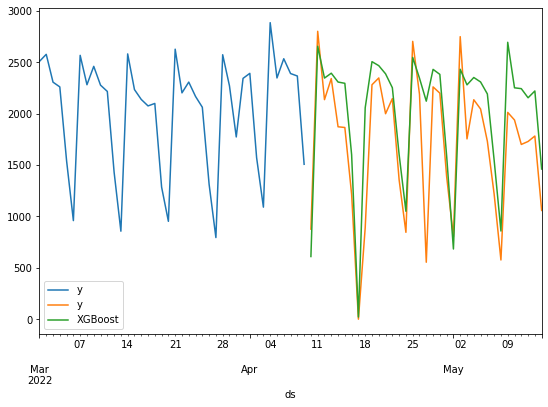

In [ ]:
FBXGBcombined_training_set.y['2022-03-01':].plot(figsize = (9,6), legend = True)
FBXGBcombined_test_set.y.plot(legend = True)
predictions_xgb.plot(legend = True)

In [ ]:
timeseries_evaluation_metrics_func(actual_value, predictions_xgb)

Evaluation metric results:-
MSE is : 207588.95371079163
MAE is : 347.3763838631766
RMSE is : 455.6193078775214
MAPE is : inf
R2 is : 0.5381918798096862



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


P: order of the autoregressive\
D: degree of first differencing involved\
Q: order of the moving average part\

# Model 3: Ensembled Model

In [ ]:
# dfprophet = pd.DataFrame(predictions_prophet)
actual = volume_ground[['Demand(y)']]
actual.reset_index(inplace=True)
actual = actual.rename(columns = {'index':'Date'})

dfprophet = pd.DataFrame(predictions_prophet)
dfprophet.reset_index(inplace=True)
dfprophet = dfprophet.rename(columns = {'ds':'Date', 'prophet':'Prophet_Prediction'})

dfxgb = pd.DataFrame(predictions_xgb)
dfxgb.reset_index(inplace=True)
dfxgb = dfxgb.rename(columns = {'ds':'Date', 'XGBoost':'prediction'})

fboxfb = dfxgb.rename(columns = {'prediction':'Prophet + XGB'}) 
fbp = dfprophet.rename(columns = {'Prophet_Prediction':'Prophet'}) 

ensembled = pd.merge(fbp , fboxfb, left_on='Date', right_on='Date')
ensembled = pd.merge(ensembled , actual, left_on='Date', right_on='Date')

ensembled = ensembled [['Date',  'Demand(y)', 'Prophet', 'Prophet + XGB']]
ensembled['Ensembled'] = (ensembled ['Prophet']+ensembled ['Prophet + XGB'])/2
ens = ensembled.Ensembled
ens.index = FBXGBcombined_test_set.ds

#**Phase 3: Future Prediction**

In this section, we repeat the modeling process with future values.\
1. Data: Each data needs to have future values. 
2. Models: Run models using future values.
3. Assessment: Review the statistic scores and compare with the testing phase.
4. Download: Get the forecasting values in CSV file.

# Prep: "Dataset" and "Holidays"

In [ ]:
# bring the date index into column
dataset_future = all_future.reset_index()
dataset_future['Date'] = dataset_future['index'].dt.strftime('%Y-%m-%d')
# data = data.drop(['index'], axis =1)

In [ ]:
# Data Transformation
dataset_future.Date = pd.to_datetime(dataset_future.Date, format = '%Y-%m-%d')
dataset_future.Date 

0     2020-01-01
1     2020-01-02
2     2020-01-03
3     2020-01-04
4     2020-01-05
5     2020-01-06
6     2020-01-07
7     2020-01-08
8     2020-01-09
9     2020-01-10
10    2020-01-11
11    2020-01-12
12    2020-01-13
13    2020-01-14
14    2020-01-15
15    2020-01-16
16    2020-01-17
17    2020-01-18
18    2020-01-19
19    2020-01-20
20    2020-01-21
21    2020-01-22
22    2020-01-23
23    2020-01-24
24    2020-01-25
25    2020-01-26
26    2020-01-27
27    2020-01-28
28    2020-01-29
29    2020-01-30
30    2020-01-31
31    2020-02-01
32    2020-02-02
33    2020-02-03
34    2020-02-04
35    2020-02-05
36    2020-02-06
37    2020-02-07
38    2020-02-08
39    2020-02-09
40    2020-02-10
41    2020-02-11
42    2020-02-12
43    2020-02-13
44    2020-02-14
45    2020-02-15
46    2020-02-16
47    2020-02-17
48    2020-02-18
49    2020-02-19
50    2020-02-20
51    2020-02-21
52    2020-02-22
53    2020-02-23
54    2020-02-24
55    2020-02-25
56    2020-02-26
57    2020-02-27
58    2020-02-

In [ ]:
# Due to the requirement of FBProphet, rename y column and datastamp variables
dataset_future = dataset_future.rename(columns= {'Demand(y)':'y'})
dataset_future = dataset_future.rename(columns= {'Date':'ds'})


In [ ]:
#Holidays
"""""""""""""""""""""""""""""""""""""""
Store holiday dates from the Holidays column
---------------------------------------
In case of Facebook Prophet, holiday data could be simpler as it couls set up
the date range to consider as holidays.
However, it can't specify more details of holiday range. For example, christmas 
holidays can last two weeks while black friday or other national holidays can be less.

If I would like to specify each of the holidays range differently, I would need 
to create each one of these per holiday >>> check challenge

"""""""""""""""""""""""""""""""""""""""
holiday_dates = dataset_future[dataset_future.Holidays == 1].ds
holidays = pd.DataFrame({'holiday': 'holi', 
                         'ds':pd.to_datetime(holiday_dates),
                         #'lower_window':0, #3 days prior to the holiday that was counted
                         #'upper_window':0  
                         #1 day after to the holiday that was counted
})                       #upper and lower can be 0 as they are manually specified
holidays.head()

holiday         ds
0    holi 2020-01-01
1    holi 2020-01-02
2    holi 2020-01-03
3    holi 2020-01-04
4    holi 2020-01-05

In [ ]:
#remove Holidays columns from dataset as the holidays are created seperately.
dataset_future = dataset_future.drop(columns = "Holidays")
dataset_future = dataset_future.fillna(0)
dataset_future.head(2)


index       y  DDVEC  FHVEC    FG    FXX    TG  ...  \
0 2020-01-01     0.0  176.0   31.0  35.0   80.0   9.5  ...   
1 2020-01-02  2288.0  191.0   51.0  53.0  110.0  38.0  ...   

   Overijssel_Std_Retail_Rec_%Change  Overijssel_Std_Park_%Change  \
0                                0.0                          0.0   
1                                0.0                          0.0   

   Overijssel_Ave_Retail_Rec_%Change  Overijssel_Ave_Park_%Change  \
0                                0.0                          0.0   
1                                0.0                          0.0   

   Overijssel_Mid_Retail_Rec_%Change  Overijssel_Mid_Park_%Change         ds  
0                                0.0                          0.0 2020-01-01  
1                                0.0                          0.0 2020-01-02  

[2 rows x 97 columns]

In [ ]:
dataset_future

index       y  DDVEC  FHVEC     FG    FXX     TG  ...  \
0   2020-01-01     0.0  176.0   31.0   35.0   80.0    9.5  ...   
1   2020-01-02  2288.0  191.0   51.0   53.0  110.0   38.0  ...   
2   2020-01-03  2129.0  244.0   47.0   64.0  150.0   75.0  ...   
3   2020-01-04  1354.0  270.0   50.0   51.0  130.0   61.0  ...   
4   2020-01-05  1045.0  219.0   39.0   40.0   90.0   65.0  ...   
5   2020-01-06  2063.0  201.0   50.0   52.0  110.0   58.0  ...   
6   2020-01-07  1703.0  208.0   56.0   58.0  140.0   67.5  ...   
7   2020-01-08  1767.0  227.0   50.0   53.0  140.0  100.5  ...   
8   2020-01-09  1590.0  200.0   65.0   69.0  150.0  113.0  ...   
9   2020-01-10  1788.0  278.0   32.0   45.0  130.0   63.5  ...   
10  2020-01-11  1113.0  202.0   70.0   70.0  150.0   57.0  ...   
11  2020-01-12  1065.0  219.0   71.0   76.0  170.0   70.0  ...   
12  2020-01-13  2022.0  187.0   62.0   64.0  170.0   75.0  ...   
13  2020-01-14  1664.0  200.0  100.0  101.0  200.0  103.5  ...   
14  2020-01-15  1739.0  207.0   81.0   85.0  190.0   92.5  ...   
15  2020-01-16  1513.0  170.0   51.0   55.0  120.0   71.5  ...   
16  2020-01-17  1466.0  208.0   55.0   65.0  160.0   81.5  ...   
17  2020-01-18  1055.0  259.0   40.0   46.0  130.0   43.5  ...   
18  2020-01-19   907.0  331.0   32.0   35.0  120.0   40.5  ...   
19  2020-01-20  2006.0  219.0   18.0   22.0   60.0   33.0  ...   
20  2020-01-21  1721.0  214.0   30.0   31.0   70.0   21.5  ...   
21  2020-01-22  1646.0  228.0   17.0   20.0   50.0   44.0  ...   
22  2020-01-23  1503.0  122.0   19.0   21.0   60.0   42.0  ...   
23  2020-01-24  1450.0  200.0   31.0   32.0   70.0   25.0  ...   
24  2020-01-25  1025.0  172.0   38.0   40.0   80.0   21.5  ...   
25  2020-01-26   934.0  177.0   47.0   49.0  110.0   54.0  ...   
26  2020-01-27  1879.0  196.0   56.0   59.0  140.0   79.0  ...   
27  2020-01-28  1628.0  242.0   75.0   80.0  190.0   51.5  ...   
28  2020-01-29  1665.0  253.0   69.0   73.0  160.0   56.0  ...   
29  2020-01-30  1519.0  221.0   76.0   80.0  160.0   83.0  ...   
30  2020-01-31  1444.0  228.0   82.0   84.0  170.0  106.0  ...   
31  2020-02-01  1134.0  239.0   85.0   88.0  170.0  103.5  ...   
32  2020-02-02  1087.0  237.0   52.0   61.0  160.0   86.0  ...   
33  2020-02-03  2141.0  255.0   70.0   73.0  150.0   89.5  ...   
34  2020-02-04  1763.0  294.0   59.0   63.0  170.0   53.0  ...   
35  2020-02-05  1818.0  270.0   19.0   25.0   70.0   47.5  ...   
36  2020-02-06  1625.0  245.0   17.0   23.0   60.0   48.5  ...   
37  2020-02-07  1564.0  139.0   41.0   43.0  100.0   45.0  ...   
38  2020-02-08  1152.0  190.0   47.0   50.0  110.0   69.5  ...   
39  2020-02-09  1104.0  209.0  128.0  134.0  280.0   97.0  ...   
40  2020-02-10  1880.0  252.0  117.0  121.0  250.0   76.0  ...   
41  2020-02-11  1621.0  261.0  124.0  125.0  220.0   56.5  ...   
42  2020-02-12  1676.0  253.0   82.0   84.0  190.0   51.5  ...   
43  2020-02-13  1535.0  190.0   46.0   59.0  150.0   56.0  ...   
44  2020-02-14  1449.0  231.0   37.0   48.0  110.0   70.0  ...   
45  2020-02-15  1058.0  194.0   89.0   90.0  220.0  103.0  ...   
46  2020-02-16  1017.0  214.0  114.0  123.0  250.0  117.5  ...   
47  2020-02-17  2099.0  229.0   97.0   99.0  220.0   78.0  ...   
48  2020-02-18  1747.0  236.0   89.0   91.0  190.0   72.0  ...   
49  2020-02-19  1762.0  252.0   62.0   72.0  160.0   60.5  ...   
50  2020-02-20  1711.0  227.0   77.0   93.0  210.0   79.0  ...   
51  2020-02-21  1682.0  234.0   83.0   86.0  170.0   70.0  ...   
52  2020-02-22  1098.0  232.0  108.0  110.0  210.0   87.0  ...   
53  2020-02-23  1125.0  261.0   78.0   91.0  230.0   81.5  ...   
54  2020-02-24  2125.0  224.0   70.0   84.0  210.0   73.0  ...   
55  2020-02-25  1752.0  252.0   71.0   73.0  170.0   61.5  ...   
56  2020-02-26  1897.0  279.0   50.0   53.0  140.0   35.0  ...   
57  2020-02-27  1836.0  236.0   19.0   45.0  140.0   27.0  ...   
58  2020-02-28  1693.0  200.0   59.0   65.0  170.0   44.5  ...   
59  2020-02-29  1297.0  209.0   91.0   98.0  240.

In [ ]:
test_set

index       y  Drenthe_Ave_Retail_Rec_%Change  \
830 2022-04-10   876.0                        3.333333   
831 2022-04-11  2801.0                       -0.500000   
832 2022-04-12  2136.0                        6.714286   
833 2022-04-13  2341.0                        4.000000   
834 2022-04-14  1872.0                        9.750000   
835 2022-04-15  1865.0                        0.000000   
836 2022-04-16  1214.0                        9.000000   
837 2022-04-17     0.0                       -7.200000   
838 2022-04-18   889.0                        5.666667   
839 2022-04-19  2281.0                       -3.428571   
840 2022-04-20  2347.0                        2.285714   
841 2022-04-21  1999.0                        3.750000   
842 2022-04-22  2146.0                        1.625000   
843 2022-04-23  1355.0                        5.200000   
844 2022-04-24   845.0                       16.666667   
845 2022-04-25  2703.0                        4.333333   
846 2022-04-26  2188.0                       30.428571   
847 2022-04-27   554.0                       60.000000   
848 2022-04-28  2260.0                        5.125000   
849 2022-04-29  2199.0                       -0.875000   
850 2022-04-30  1387.0                       -2.300000   
851 2022-05-01   803.0                       12.400000   
852 2022-05-02  2749.0                        6.666667   
853 2022-05-03  1754.0                       14.571429   
854 2022-05-04  2135.0                       10.000000   
855 2022-05-05  2045.0                       13.142857   
856 2022-05-06  1731.0                        5.000000   
857 2022-05-07  1217.0                        3.900000   
858 2022-05-08   576.0                        7.000000   
859 2022-05-09  2012.0                       -0.833333   
860 2022-05-10  1938.0                        4.285714   
861 2022-05-11  1700.0                        6.571429   
862 2022-05-12  1729.0                        5.125000   
863 2022-05-13  1782.0                       -3.125000   
864 2022-05-14  1058.0                        5.200000   

     Drenthe_Ave_Park_%Change  Drenthe_Std_Retail_Rec_%Change  \
830                 38.428571                        4.760952   
831                103.000000                        7.063993   
832                133.000000                        7.250616   
833                124.000000                       11.860298   
834                113.000000                       11.671088   
835                109.500000                        9.211794   
836                101.000000                       14.959204   
837                112.500000                       19.879638   
838                307.000000                       16.560998   
839                120.000000                        5.533448   
840                105.000000                        9.214378   
841                 51.000000                       12.825755   
842                 80.600000                        7.190023   
843                 77.333333                       14.860836   
844                 73.750000                       12.209286   
845                129.000000                        8.115828   
846                172.000000                        9.089502   
847                215.000000                       25.638513   
848                 76.500000                        9.977654   
849                104.800000                        7.278883   
850                 71.000000                       11.450861   
851                 66.000000                       15.175638   
852                216.000000                        7.312090   
853                202.000000                        7.678045   
854                229.000000                        8.679478   
855                229.000000                        9.651055   
856                114.250000                        9.710083   
857                 70.750000                       12.077987   
858                 69.166667      

# Model 1: Prophet



**Benefit of Prophet Model**\
(+) dynamic holidays; it allows us to further dig and study about holidays\
(+) customizable and intuitive for non-experts; built-in cross validation and hyperparameter tuning\


**Methodological framework**\
y(t) = c(t)+s(t)+h(t)+x(t)+e

where c(t) = trent, s(t) = seasonality, and h(t) = holiday effects, x(t) = external variables/regressors, and e = error

In [ ]:
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 5)

In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Seperating the dataset into Training and Testing
"""""""""""""""""""""""""""""""""""""""""""""""""""
prophet_training_set_future = dataset_future.iloc[:-test_days, :]
prophet_test_set_future = dataset_future.iloc[-test_days:, :]
prophet_test_set_future

index    y  DDVEC  FHVEC    FG    FXX     TG  ...  \
866 2022-05-16  0.0  215.5   30.0  49.0  130.0  175.5  ...   
867 2022-05-17  0.0  151.5   13.0  28.0   80.0  180.5  ...   
..         ...  ...    ...    ...   ...    ...    ...  ...   
899 2022-06-18  0.0  331.5   31.0  41.0  110.0  203.0  ...   
900 2022-06-19  0.0   15.0   41.0  46.0  130.0  145.0  ...   

     Overijssel_Std_Retail_Rec_%Change  Overijssel_Std_Park_%Change  \
866                          12.181097                    33.234019   
867                          14.356038                    35.355339   
..                                 ...                          ...   
899                          19.605249                    54.447222   
900                          29.133314                    40.475301   

     Overijssel_Ave_Retail_Rec_%Change  Overijssel_Ave_Park_%Change  \
866                          -0.071429                        61.50   
867                           8.687500                        90.00   
..                                 ...                          ...   
899                           0.050000                       224.00   
900                          14.250000                        42.25   

     Overijssel_Mid_Retail_Rec_%Change  Overijssel_Mid_Park_%Change         ds  
866                               -4.5                         61.5 2022-05-16  
867                                3.0                         90.0 2022-05-17  
..                                 ...                          ...        ...  
899                               -7.5                        224.0 2022-06-18  
900                                7.5                         44.0 2022-06-19  

[35 rows x 97 columns]

**Facebook Prophet Component Descriptions**


*   **Growth** : Linear / Logistic ; how does the trend shape like?
*   **Holidays**: use the one prepared already above
*   **Seasonality**: yearly, weekly, daily
*   **Seasonality_mode**: multiplicative or additive
*   **Seasonality_Prior_scale**: strength of the seasonality (continous number). higher number means stronger seasonality
*   **Holiday_Prior_scale**: strength of the holiday (continous number)
*   **Changepoint_prior_scale**: flexibility of the automatic changepoint selection: how to detect the changes in trend and whether it should detect changes in trend easily or more robust




In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Facebook Prophet Model
"""""""""""""""""""""""""""""""""""""""""""""""""""
mf = Prophet(growth = 'linear',
            yearly_seasonality=True, #Jan to Feb etc
            weekly_seasonality=True, #monday to sunday seasonality
            daily_seasonality= True, #if data is daily, then True
            holidays = holidays, #it was already defined earlier
            seasonality_mode ='additive', #use additive seasonality during the pandemic so that it’s not biased by 2020’s abnormal baseline, especially when COVID greatly impacts your time series data.
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05 #this is more to leave it to the model and reflect how easy it is to have a break of trends
            )



# Selected Features
mf.add_regressor('Drenthe_Std_Retail_Rec_%Change')
mf.add_regressor('Drenthe_Std_Park_%Change')
mf.add_regressor('Groningen_Std_Retail_Rec_%Change')
mf.add_regressor('Zeeland_Std_Retail_Rec_%Change')
mf.add_regressor('South Holland_Std_Retail_Rec_%Change')
mf.add_regressor('South Holland_Std_Park_%Change')
mf.add_regressor('North Brabant_Std_Retail_Rec_%Change')
mf.add_regressor('North Brabant_Std_Park_%Change')
mf.add_regressor('Friesland_Std_Retail_Rec_%Change')
mf.add_regressor('Gelderland_Std_Retail_Rec_%Change')
mf.add_regressor('Gelderland_Std_Park_%Change')
mf.add_regressor('Utrecht_Std_Retail_Rec_%Change')
mf.add_regressor('Utrecht_Std_Park_%Change')
mf.add_regressor('Limburg_Std_Retail_Rec_%Change')
mf.add_regressor('Limburg_Std_Park_%Change')
mf.add_regressor('North Holland_Std_Retail_Rec_%Change')
mf.add_regressor('North Holland_Std_Park_%Change')
mf.add_regressor('Overijssel_Std_Retail_Rec_%Change')
mf.add_regressor('stringency_index')
mf.add_regressor('DDVEC')
mf.add_regressor('FHVEC')
mf.add_regressor('FG')
mf.add_regressor('FXX')
mf.add_regressor('TG')
mf.add_regressor('TN')
mf.add_regressor('TX')
mf.add_regressor('NG')

# # no change ; 18
mf.add_regressor('christmas_NY')
mf.add_regressor('easter_whit')
mf.add_regressor('Mon')
mf.add_regressor('Tue')
mf.add_regressor('Wed')
mf.add_regressor('Thu')
mf.add_regressor('Fri')
mf.add_regressor('Sat')
mf.add_regressor('Sun')



mf.fit(prophet_training_set_future)

In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Forecasting
"""""""""""""""""""""""""""""""""""""""""""""""""""
# Create Future Dataframe
ffuture = mf.make_future_dataframe(periods = len(prophet_test_set_future),
                                 freq = "D")
ffuture.tail(1)

ds
900 2022-06-19

In [ ]:
# merge regressors
ffuture = pd.concat([ffuture, dataset_future.iloc[:, 1:-1]], # do not include "ds" and 'y' columns
                    axis = 1)


In [ ]:
ffuture

ds       y  DDVEC  FHVEC    FG    FXX     TG  ...  \
0   2020-01-01     0.0  176.0   31.0  35.0   80.0    9.5  ...   
1   2020-01-02  2288.0  191.0   51.0  53.0  110.0   38.0  ...   
..         ...     ...    ...    ...   ...    ...    ...  ...   
899 2022-06-18     0.0  331.5   31.0  41.0  110.0  203.0  ...   
900 2022-06-19     0.0   15.0   41.0  46.0  130.0  145.0  ...   

     North Holland_Ave_Park_%Change  Overijssel_Std_Retail_Rec_%Change  \
0                          0.000000                           0.000000   
1                          0.000000                           0.000000   
..                              ...                                ...   
899                       56.416667                          19.605249   
900                       -1.384615                          29.133314   

     Overijssel_Std_Park_%Change  Overijssel_Ave_Retail_Rec_%Change  \
0                       0.000000                               0.00   
1                       0.000000                               0.00   
..                           ...                                ...   
899                    54.447222                               0.05   
900                    40.475301                              14.25   

     Overijssel_Ave_Park_%Change  Overijssel_Mid_Retail_Rec_%Change  \
0                           0.00                                0.0   
1                           0.00                                0.0   
..                           ...                                ...   
899                       224.00                               -7.5   
900                        42.25                                7.5   

     Overijssel_Mid_Park_%Change  
0                            0.0  
1                            0.0  
..                           ...  
899                        224.0  
900                         44.0  

[901 rows x 96 columns]

In [ ]:
#Forecasting
fforecast = mf.predict(ffuture)
fforecast

ds       trend   yhat_lower   yhat_upper  trend_lower  \
0   2020-01-01  354.779016 -1057.183830   100.807250   354.779016   
1   2020-01-02  357.519398  1471.166519  2643.966343   357.519398   
..         ...         ...          ...          ...          ...   
899 2022-06-18  421.279933    92.069710  1231.178340   414.317880   
900 2022-06-19  418.230580  -122.349382  1044.712932   411.007939   

     trend_upper      DDVEC  ...      yearly  yearly_lower  yearly_upper  \
0     354.779016   1.073864  ...  499.825630    499.825630    499.825630   
1     357.519398  -0.108547  ...  510.380210    510.380210    510.380210   
..           ...        ...  ...         ...           ...           ...   
899   426.587014 -11.183801  ... -126.512615   -126.512615   -126.512615   
900   423.817051  13.765081  ... -124.320583   -124.320583   -124.320583   

     multiplicative_terms  multiplicative_terms_lower  \
0                     0.0                         0.0   
1                     0.0                         0.0   
..                    ...                         ...   
899                   0.0                         0.0   
900                   0.0                         0.0   

     multiplicative_terms_upper         yhat  
0                           0.0  -484.148917  
1                           0.0  2030.358122  
..                          ...          ...  
899                         0.0   650.332886  
900                         0.0   478.635798  

[901 rows x 139 columns]

In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Prediction
"""""""""""""""""""""""""""""""""""""""""""""""""""
predictions_prophet_future = fforecast.yhat[-test_days:].rename('prophet')
predictions_prophet_future[:5]

866    2051.772481
867    1762.390730
868    1580.788116
869    1691.630082
870    1540.487665
Name: prophet, dtype: float64

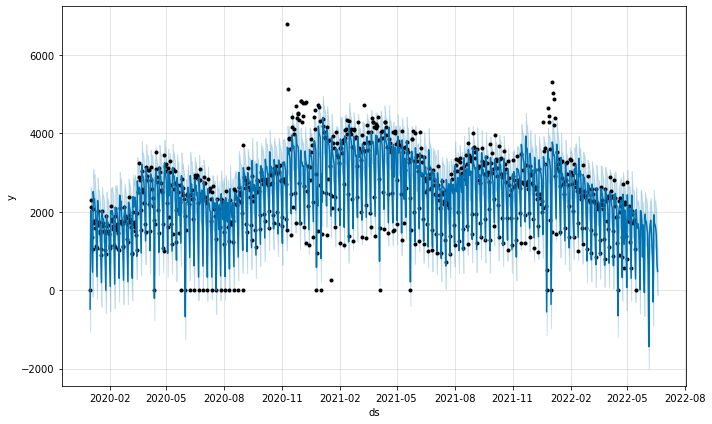

In [ ]:
# Visualization
mf.plot(fforecast);

Blue line is the actual result, while blue means the result of forecast

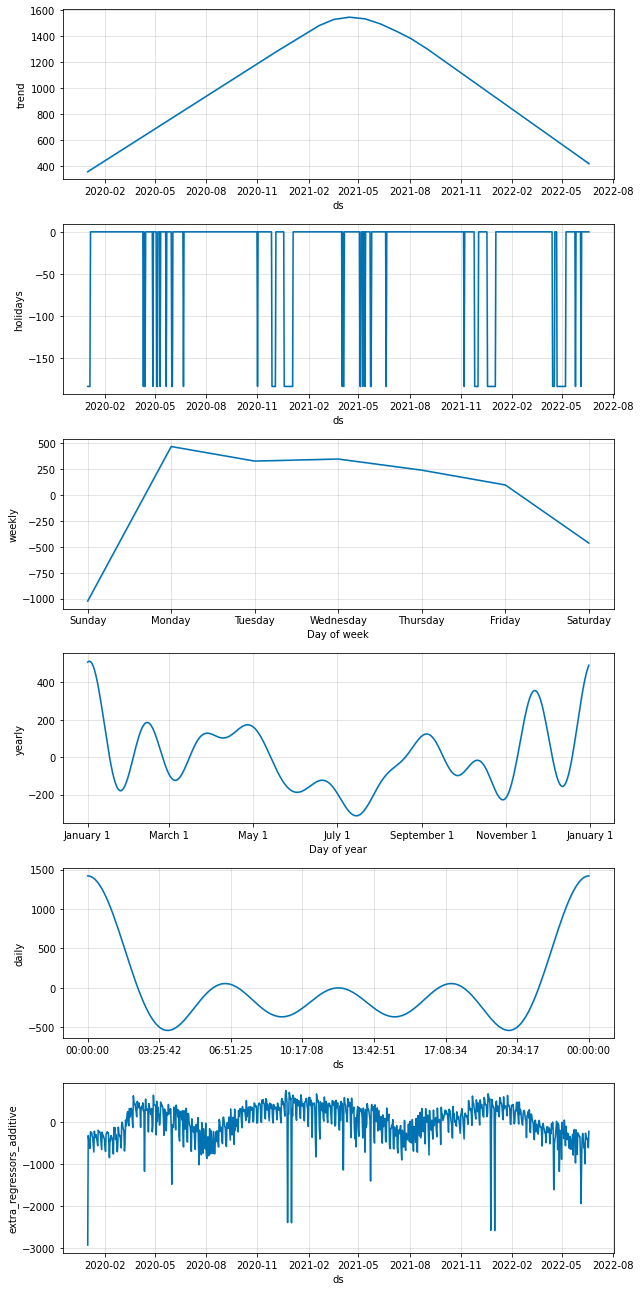

In [ ]:
#plot components
mf.plot_components(fforecast);

Interpretation of the components:


*   Trend: annual trend. July is the peak season
*   Holiday: the positive part means that that day of holidays are giving more calls to CSC while negative means opposite
*   Week: Monday and Tuesday seems to haave more higher demand of call compared to the weekends
*   Yearly: doesn't seem to have really strong seasonality defined. March has higher demands than Feburary for example. Since the data contains 2.5 years, so it may not be enough to define the seasonality clearly.
*   Regressors: the regressors seem to have more impact on the outcome from 2021 or later.



In [ ]:
predictions_prophet_future = predictions_prophet_future.rename('prophet')
predictions_prophet_future.index = prophet_test_set_future['ds']
predictions_prophet_future

ds
2022-05-16    2051.772481
2022-05-17    1762.390730
                 ...     
2022-06-18     650.332886
2022-06-19     478.635798
Name: prophet, Length: 35, dtype: float64

Text(0.5, 0, 'Date')

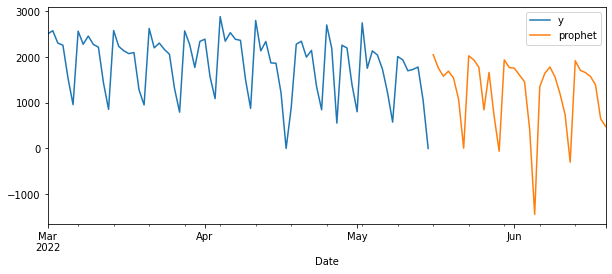

In [ ]:
# Visualization
prophet_training_set_future.index = prophet_training_set_future.ds
prophet_test_set_future.index = prophet_test_set_future.ds


prophet_training_set_future.y['2022-03-01':].plot(figsize = (10,4), legend = True)
# prophet_test_set_future.y.plot(legend = True)
predictions_prophet_future.plot(legend=True)

plt.xlabel('Date')

In [ ]:
'''no metrics can be applied as there are no values to compare with for y and yhat'''
# timeseries_evaluation_metrics_func(actual_value_future, predictions_prophet_future)

'no metrics can be applied as there are no values to compare with for y and yhat'

# Model 2: Hybrid

This combined model would meet both seasonality and nonlinearity of the dataset.

**Pros of XGBoost**
* XGBoost gives different weights depending on how difficult it is to predict the outcome over testing multiple trees. Thus, it gives greate weight on the predictor that had wrong outcome. This process continues until the model find the optimal wy for each observations.

* Helps preventing overfitting the model by looking at a fraction of the full dataset per tree. Thus, any dataset comes in the future won't be too must or less influenced.

* Weights are also distributed on different predictors per trees (not only on the data). thus, it creates more and more optimized model that sees what is important and slightly ignores predictions that are not as important.

* Treats NA values as information unlike other models

* non-linear relationship between dependent and independent variables


**Cons of XGBoost**
* complex programming
* can need intense optimization


In [ ]:
# Spliting trainig and test set
FBXGB_training_set = dataset_future.iloc[:-test_days, :]
FBXGB_test_set = dataset_future.iloc[-test_days:, :]
FBXGB_test_set

index    y  DDVEC  FHVEC    FG    FXX     TG  ...  \
866 2022-05-16  0.0  215.5   30.0  49.0  130.0  175.5  ...   
867 2022-05-17  0.0  151.5   13.0  28.0   80.0  180.5  ...   
..         ...  ...    ...    ...   ...    ...    ...  ...   
899 2022-06-18  0.0  331.5   31.0  41.0  110.0  203.0  ...   
900 2022-06-19  0.0   15.0   41.0  46.0  130.0  145.0  ...   

     Overijssel_Std_Retail_Rec_%Change  Overijssel_Std_Park_%Change  \
866                          12.181097                    33.234019   
867                          14.356038                    35.355339   
..                                 ...                          ...   
899                          19.605249                    54.447222   
900                          29.133314                    40.475301   

     Overijssel_Ave_Retail_Rec_%Change  Overijssel_Ave_Park_%Change  \
866                          -0.071429                        61.50   
867                           8.687500                        90.00   
..                                 ...                          ...   
899                           0.050000                       224.00   
900                          14.250000                        42.25   

     Overijssel_Mid_Retail_Rec_%Change  Overijssel_Mid_Park_%Change         ds  
866                               -4.5                         61.5 2022-05-16  
867                                3.0                         90.0 2022-05-17  
..                                 ...                          ...        ...  
899                               -7.5                        224.0 2022-06-18  
900                                7.5                         44.0 2022-06-19  

[35 rows x 97 columns]

**XGBoost Preparation**

In [ ]:
prophet_variables = fforecast.loc[:, ['trend', 
                                     'weekly',
                                     'holi',
                                     'yearly',
                                     'daily'#choose variables from "forecast" dataframe
]]

In [ ]:
dataset1 = dataset_future[[

'y', 'ds', 

#selected features
'Drenthe_Std_Retail_Rec_%Change',
'Drenthe_Std_Park_%Change',
'Groningen_Std_Retail_Rec_%Change',
'Zeeland_Std_Retail_Rec_%Change',
'South Holland_Std_Retail_Rec_%Change',
'South Holland_Std_Park_%Change',
'North Brabant_Std_Retail_Rec_%Change',
'North Brabant_Std_Park_%Change',
'Friesland_Std_Retail_Rec_%Change',
'Gelderland_Std_Retail_Rec_%Change',
'Gelderland_Std_Park_%Change',
'Utrecht_Std_Retail_Rec_%Change',
'Utrecht_Std_Park_%Change',
'Limburg_Std_Retail_Rec_%Change',
'Limburg_Std_Park_%Change',
'North Holland_Std_Retail_Rec_%Change',
'North Holland_Std_Park_%Change',
'Overijssel_Std_Retail_Rec_%Change',
'stringency_index',
'DDVEC',
'FHVEC',
'FG',
'FXX',
'TG',
'TN',
'TX',
'NG',


# no change ; 18
'christmas_NY',
'easter_whit',
'Mon',
'Tue',
'Wed',
'Thu',
'Fri',
'Sat',
'Sun',

        ]]

Chooing Only XGB for now with/without Seasonality

In [ ]:
# merge the dataset variables and prphet result
df_xgb = pd.concat([dataset1, prophet_variables], axis = 1) 

In [ ]:
# Now you can see the seasonality data from Prophet is with the other features
df_xgb

y         ds  Drenthe_Std_Retail_Rec_%Change  \
0       0.0 2020-01-01                         0.00000   
1    2288.0 2020-01-02                         0.00000   
..      ...        ...                             ...   
899     0.0 2022-06-18                        14.46874   
900     0.0 2022-06-19                         9.58471   

     Drenthe_Std_Park_%Change  Groningen_Std_Retail_Rec_%Change  \
0                    0.000000                          0.000000   
1                    0.000000                          0.000000   
..                        ...                               ...   
899                 66.613312                         25.142096   
900                 37.541089                         10.733126   

     Zeeland_Std_Retail_Rec_%Change  South Holland_Std_Retail_Rec_%Change  \
0                          0.000000                              0.000000   
1                          0.000000                              0.000000   
..                              ...                                   ...   
899                       40.209940                             27.195979   
900                       34.751156                             20.940832   

     ...  Sat  Sun       trend       weekly        holi      yearly  \
0    ...  0.0  0.0  354.779016   348.350241 -184.021533  499.825630   
1    ...  0.0  0.0  357.519398   240.860703 -184.021533  510.380210   
..   ...  ...  ...         ...          ...         ...         ...   
899  ...  0.0  1.0  421.279933  -462.741707    0.000000 -126.512615   
900  ...  0.0  0.0  418.230580 -1022.299091    0.000000 -124.320583   

           daily  
0    1420.071471  
1    1420.071471  
..           ...  
899  1420.071471  
900  1420.071471  

[901 rows x 43 columns]

In [ ]:
# Create Training and Testing dataset
FBXGBcombined_training_set = df_xgb.iloc[:-test_days, :]
FBXGBcombined_test_set = df_xgb.iloc[-test_days:, :]
FBXGBcombined_training_set

y         ds  Drenthe_Std_Retail_Rec_%Change  \
0       0.0 2020-01-01                        0.000000   
1    2288.0 2020-01-02                        0.000000   
..      ...        ...                             ...   
864  1058.0 2022-05-14                       17.370473   
865     0.0 2022-05-15                       15.498387   

     Drenthe_Std_Park_%Change  Groningen_Std_Retail_Rec_%Change  \
0                    0.000000                          0.000000   
1                    0.000000                          0.000000   
..                        ...                               ...   
864                 61.158265                         24.020453   
865                 38.890873                         14.204459   

     Zeeland_Std_Retail_Rec_%Change  South Holland_Std_Retail_Rec_%Change  \
0                          0.000000                              0.000000   
1                          0.000000                              0.000000   
..                              ...                                   ...   
864                       24.680820                             26.598359   
865                       27.463916                             21.069072   

     ...  Sat  Sun       trend       weekly        holi      yearly  \
0    ...  0.0  0.0  354.779016   348.350241 -184.021533  499.825630   
1    ...  0.0  0.0  357.519398   240.860703 -184.021533  510.380210   
..   ...  ...  ...         ...          ...         ...         ...   
864  ...  1.0  0.0  528.007290  -462.741707    0.000000    2.526721   
865  ...  0.0  1.0  524.957937 -1022.299091    0.000000  -13.847175   

           daily  
0    1420.071471  
1    1420.071471  
..           ...  
864  1420.071471  
865  1420.071471  

[866 rows x 43 columns]

In [ ]:
# isolate X and Y
y_train = FBXGBcombined_training_set.y
y_test = FBXGBcombined_test_set.y

X_train = FBXGBcombined_training_set.drop(columns = {'y', 'ds'})
X_test = FBXGBcombined_test_set.drop(columns = {'y', 'ds'})

In [ ]:
# create XGBoost Matrices
Train = xgb.DMatrix(data = X_train, label = y_train)
Test = xgb.DMatrix(data = X_test, label = y_test)

**Parameters**
* **Minimum Child Weight**: relates to the sum of the weight of each obervation. Low values can mean that maybe not a lot of observations are in the round.
* **ETA**: learning rate; how fast does the model needs to learn? lower learning rate usually
* **Max depth**: how many splits should the tree have? the larger trees, further detailed.
* **Gamma**: how easy and fast should the tree be split? faster? longer?
* **Subsample**: share of observation in each tree? 
* **Colsample by tree**: how much of the tree should be analyzed per round?
* **numbe of rounds**: How many times do we want the analysis to be run?

In [ ]:
# XGBoost Parameters
parameters = {'learning_rate': 0.1, # this is usually changed
              'max_depth': 3, # this is usually changed
              'colsample_bytree': 1,
              'subsample': 1,
              'min_child_weight':1,
              'gamma': 1,
              'random_state': 1502,
              'eval_metric': 'rmse',
              'objective': "reg:squarederror"
}

In [ ]:
# Modeling
model_fbxgb_f = xgb.train(params = parameters,
                  dtrain = Train,
                  num_boost_round = 100, # after 100 the rmse may increase more again.
                  evals = [(Test, 'y')],
                  verbose_eval = 15 
                  ) #how much do we want the model to speak with us? Larger the value, more communicate with us
                  

[0]	y-rmse:157.39
[15]	y-rmse:1388.01
[30]	y-rmse:1600.67
[45]	y-rmse:1619.14
[60]	y-rmse:1574.2
[75]	y-rmse:1550.61
[90]	y-rmse:1542.85
[99]	y-rmse:1541.95


In [ ]:
# Forecasting
predictions_xgb_future = pd.Series(model_fbxgb_f.predict(Test), name = 'XGBoost')
predictions_xgb_future.index = FBXGBcombined_test_set.ds

In [ ]:
predictions_xgb_future[:5]

ds
2022-05-16    2126.776855
2022-05-17    1758.879150
2022-05-18    1783.963867
2022-05-19    1720.754761
2022-05-20    1654.014893
Name: XGBoost, dtype: float32

In [ ]:
# Visualization
FBXGBcombined_training_set.index = FBXGBcombined_training_set.ds
FBXGBcombined_test_set.index = FBXGBcombined_test_set.ds

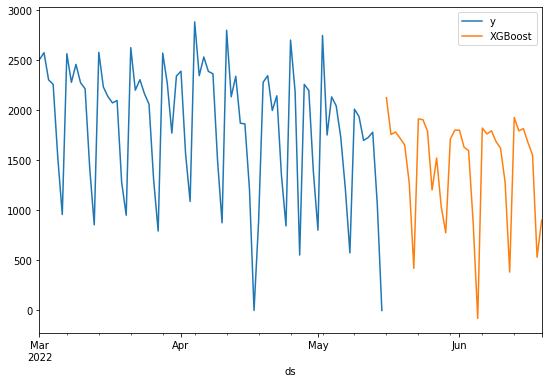

In [ ]:
FBXGBcombined_training_set.y['2022-03-01':].plot(figsize = (9,6), legend = True)
# FBXGBcombined_test_set.y.plot(legend = True)f
predictions_xgb_future.plot(legend = True)

In [ ]:
# timeseries_evaluation_metrics_func(actual_value_future, predictions_xgb_future)

# Model 3: Ensembled Model

In [ ]:
dfprophet = pd.DataFrame(predictions_prophet_future)
dfprophet.reset_index(inplace=True)
dfprophet = dfprophet.rename(columns = {'ds':'Date', 'prophet':'Prophet_Prediction'})

dfxgb = pd.DataFrame(predictions_xgb_future)
dfxgb.reset_index(inplace=True)
dfxgb = dfxgb.rename(columns = {'ds':'Date', 'XGBoost':'prediction'})

fboxfb = dfxgb.rename(columns = {'prediction':'Prophet + XGB'}) 
fbp = dfprophet.rename(columns = {'Prophet_Prediction':'Prophet'}) 

ensembled2 = pd.merge(fbp , fboxfb, left_on='Date', right_on='Date')

ensembled2 = ensembled2 [['Date', # 'Demand(y)',
                        'Prophet', 'Prophet + XGB']]
ensembled2['Ensembled'] = (ensembled2 ['Prophet'] + ensembled2 ['Prophet + XGB'])/2
ens2 = ensembled2.Ensembled
ens2.index = FBXGBcombined_test_set.ds

In [ ]:
ensembled2

Date      Prophet  Prophet + XGB    Ensembled
0  2022-05-16  2051.772481    2126.776855  2089.274668
1  2022-05-17  1762.390730    1758.879150  1760.634940
..        ...          ...            ...          ...
33 2022-06-18   650.332886     531.921021   591.126953
34 2022-06-19   478.635798     902.163696   690.399747

[35 rows x 4 columns]

# **Phase 4: Prediction Result (IS)**

Assessment Result and Graph for Test Models

In [ ]:
ensembled.loc[ensembled['Demand(y)']==0, ['Prophet','Prophet + XGB','Ensembled']]=0

ensembled['ratio'] = round((ensembled['Prophet + XGB']-ensembled['Demand(y)'])/ensembled['Demand(y)']*100, 2)
ensembled['ratio'] = ensembled['ratio'].replace(np.nan, 0)
# comparison = comparison[['Date', 'Prophet + XGB', 'Demand(y)', 'ratio']]
ensembled = ensembled.loc[(ensembled['Demand(y)']>0)]
pd.set_option('display.max_rows', None)
ensembled

Date  Demand(y)      Prophet  Prophet + XGB    Ensembled   ratio
0  2022-04-10      876.0  1243.595657     609.656311   926.625984  -30.40
1  2022-04-11     2801.0  2838.755309    2655.504883  2747.130096   -5.19
2  2022-04-12     2136.0  2704.395085    2345.876465  2525.135775    9.83
3  2022-04-13     2341.0  2941.110241    2393.333984  2667.222113    2.24
4  2022-04-14     1872.0  2730.853176    2307.215088  2519.034132   23.25
5  2022-04-15     1865.0  2611.453018    2294.979736  2453.216377   23.06
6  2022-04-16     1214.0  2225.705500    1599.898071  1912.801786   31.79
8  2022-04-18      889.0  1675.965680    2056.895752  1866.430716  131.37
9  2022-04-19     2281.0  2618.489281    2505.593506  2562.041394    9.85
10 2022-04-20     2347.0  2711.278127    2466.552734  2588.915431    5.09
11 2022-04-21     1999.0  3213.332861    2387.301270  2800.317065   19.42
12 2022-04-22     2146.0  2699.029615    2252.193848  2475.611732    4.95
13 2022-04-23     1355.0  1997.882601    1600.661865  1799.272233   18.13
14 2022-04-24      845.0  1296.085753    1049.924438  1173.005096   24.25
15 2022-04-25     2703.0  2978.191281    2547.052490  2762.621886   -5.77
16 2022-04-26     2188.0  2749.756700    2344.593506  2547.175103    7.16
17 2022-04-27      554.0  1028.682851    2121.229248  1574.956049  282.89
18 2022-04-28     2260.0  2516.515412    2430.582031  2473.548722    7.55
19 2022-04-29     2199.0  2140.890026    2381.792236  2261.341131    8.31
20 2022-04-30     1387.0  1895.629168    1589.086914  1742.358041   14.57
21 2022-05-01      803.0   588.707698     682.851196   635.779447  -14.96
22 2022-05-02     2749.0  2798.221658    2431.601074  2614.911366  -11.55
23 2022-05-03     1754.0  2000.189291    2279.941162  2140.065227   29.99
24 2022-05-04     2135.0  2383.237990    2351.538818  2367.388404   10.14
25 2022-05-05     2045.0  2374.264098    2308.060547  2341.162322   12.86
26 2022-05-06     1731.0  2015.811667    2191.459961  2103.635814   26.60
27 2022-05-07     1217.0  1361.179236    1547.143555  1454.161395   27.13
28 2022-05-08      576.0   455.375626     857.773682   656.574654   48.92
29 2022-05-09     2012.0  2940.193354    2694.115967  2817.154660   33.90
30 2022-05-10     1938.0  2186.322170    2251.145996  2218.734083   16.16
31 2022-05-11     1700.0  2122.967497    2243.007324  2182.987411   31.94
32 2022-05-12     1729.0  2254.910729    2154.214600  2204.562664   24.59
33 2022-05-13     1782.0  2064.025382    2220.339844  2142.182613   24.60
34 2022-05-14     1058.0  1208.226885    1460.638062  1334.432473   38.06

In [ ]:
print('------IS Prophet------')
timeseries_evaluation_metrics_func(ensembled['Demand(y)'], ensembled['Prophet'])

print('------IS XGB------')
timeseries_evaluation_metrics_func(ensembled['Demand(y)'], ensembled['Prophet + XGB'])

print('------IS Ensembled------')
timeseries_evaluation_metrics_func(ensembled['Demand(y)'], ensembled['Ensembled'])


------IS Prophet------
Evaluation metric results:-
MSE is : 271235.55560676835
MAE is : 437.3612919007769
RMSE is : 520.8027991541217
MAPE is : 29.61573496755532
R2 is : 0.27723068252555183

------IS XGB------
Evaluation metric results:-
MSE is : 213681.84857099032
MAE is : 356.98306633444395
RMSE is : 462.25734020239236
MAPE is : 29.89603931253793
R2 is : 0.43059572885702035

------IS Ensembled------
Evaluation metric results:-
MSE is : 204309.86046501994
MAE is : 376.9368110640012
RMSE is : 452.00648276879826
MAPE is : 27.905984162024843
R2 is : 0.45556953965250224



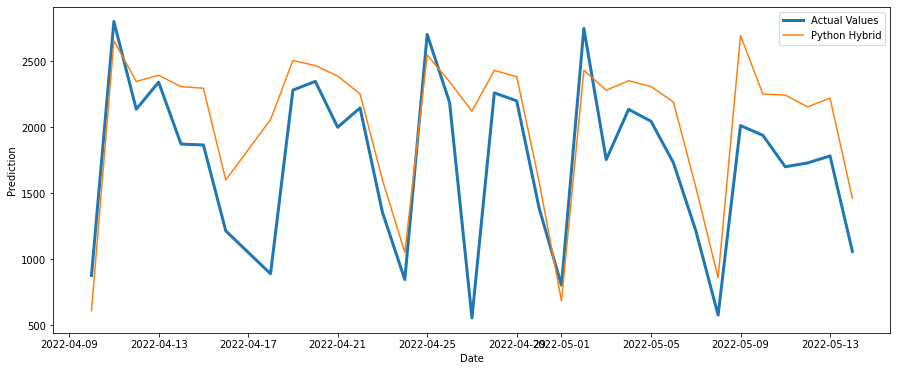

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(x= 'Date', y='Demand(y)', data= ensembled, palette = colors,  linewidth = 3, label = 'Actual Values')
#sns.lineplot(x= 'Date', y='Prophet', data= ensembled, palette = colors, label = 'Prophet')
sns.lineplot(x= 'Date', y='Prophet + XGB', data= ensembled, palette = colors, label = 'Python Hybrid')
#sns.lineplot(x= 'Date', y='Ensembled', data= ensembled, palette = colors, label = 'Ensembled')

plt.xlabel('Date')
plt.ylabel('Prediction')
# plt.title('Multivariate Time Series Forecasting Prediction Comparison',)
plt.legend()
# fig.autofmt_xdate()
plt.show()

[Note] This graph helps to see if it is ready to consider Prophet model.\
The more days are added, Prophet model will perform better, and as a result, Ensembled model would also perform better. If you still see the orange and red lines are way out from the blue line, these models are not ready for use. Then, rely on tehe XGB model.

# **Phase 5: Feature Importance**

Shapely Additive Explanations (ShAP):

This method is considered somewhat better than the traditional sckit-learn methods because many of these methods can be inconsistent, which means that the features that are most important may not always be given the highest feature importance score.

the tree-based models which might give two equally important features different scores based on what level of splitting was done using the features.

The features which split the model first might be given higher importance. This is the motivation for using the latest feature attribution method, Shapley Additive Explanations.

We estimate how important a model is by seeing how well the model performs with and without that feature for every combination of features.

This value is the average marginal contribution of a feature value across all the possible combinations of features.The computation time increases exponentially with the number of features. [Link](https://towardsdatascience.com/a-novel-approach-to-feature-importance-shapley-additive-explanations-d18af30fc21b/)







In [ ]:
!pip install shap 
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.2 MB/s 


In [ ]:
explainer = shap.TreeExplainer(model_fbxgb_f)

In [ ]:
shap_values = explainer.shap_values(X_train, check_additivity=False)

SHAP summary plot gives a general overview of each feature a SHAP dependence plot show how the model output varies by feauture value. Note that every dot is a data point, and the vertical dispersion at a single feature value results from interaction effects in the model.

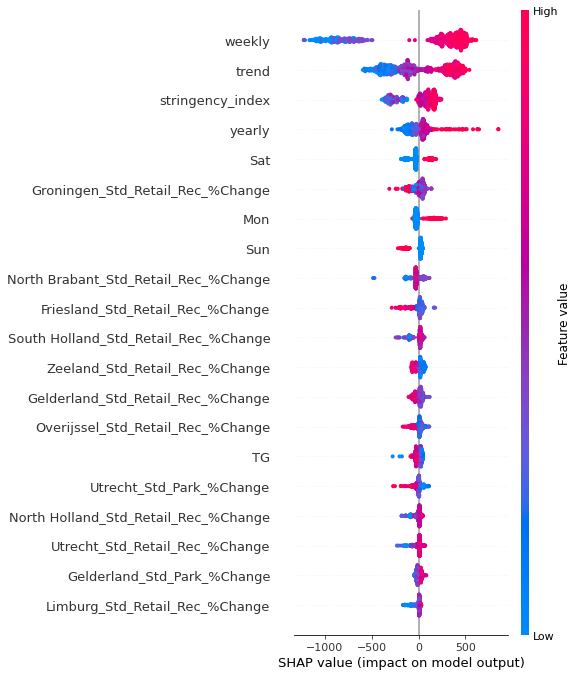

In [ ]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

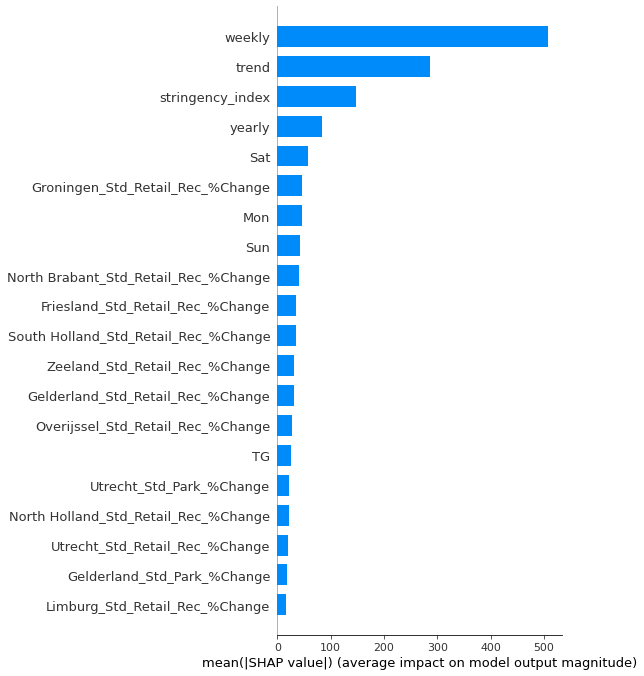

In [ ]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_type='bar')

# **Phase 6: Convert the Result to CSV (*)**



In [ ]:
# # XGB model prediction
round(dfxgb).to_csv('# Forecasting_2022-05-25.csv', index = False)

# # Prophet model prediction
# round(dfprophet).to_csv('Prophet_Forecasting_Result.csv', index = False)

# # Ensembled (Prophet+XGB) model prediction
# round(ens).to_csv('Ensembled_Forecasting_Result.csv', index = False)

# # Download predictions of all models
# round(ensembled).to_csv('Forecasting_CV70__XGB.csv', index = False)

# **Phase 7: Statistical Analysis for Forecasters (*)**

# Behind the scene (Don't touch)

Line plot of the forecasted values

Correlation feature selection.\
We can add or remove features to include in the correlation plot.

In [ ]:
cols_GM = ['retail_and_recreation_percent_change_from_baseline',
           'parks_percent_change_from_baseline'
           ]
df_GM = GM_region_1.groupby('Date', as_index=False, sort=True)[cols_GM].std()
df_GM.set_index('Date', inplace=True)
df_GM = df_GM.asfreq("D")

df_selectfeatures = [all, df_GM
       ] # do not include CCI as it is difficult to forecast the value
# nan_value = 0

# solution 1 (fast)
df_selectfeatures = pd.concat(df_selectfeatures, join='outer', axis=1)
df_selectfeatures = df_selectfeatures.reindex(new_date_range)

df_selectfeatures = df_selectfeatures.rename(columns = {'TG' : "Ave Temp", 
                                                        'DDVEC': 'Wind Direction', 
                                                        'FHVEC': 'Vector Ave Wind Speed',
                                                        'FG': 'Daily Ave Wind Speed',
                                                        'FXX': 'Highest Wind Gust', 
                                                        'TN': 'Min Temp', 
                                                        'TX':"Max Temp", 
                                                        'SQ':'Sun Duration',
                                                        'NG':'Cloud',
                                                        'RH':'Sun Precipitation',
                                                        'retail_and_recreation_percent_change_from_baseline':'Google Retail Movement Change',
                                                        'parks_percent_change_from_baseline':'Google Park Movement Change'
                                                        })


In [ ]:
df_selectfeatures = df_selectfeatures[['Demand(y)', 
 

"Ave Temp", 
'Daily Ave Wind Speed',
"Max Temp", 
'Sun Duration','Cloud',
'stringency_index', 'new_cases_smoothed', 'new_deaths_smoothed',
 'Google Retail Movement Change',
 'Google Park Movement Change',
]]

############# DO NOT Touch###################
scaler = MinMaxScaler()
# transform data
scaled = scaler.fit_transform(df_selectfeatures)
x_scaled = pd.DataFrame(scaled)
df_scaled = pd.DataFrame(x_scaled)
df_scaled.columns = df_selectfeatures.columns
df_scaled.index = df_selectfeatures.index
#df_scaled = df_scaled.reset_index().rename(columns={'index': 'Date'})
df_scaled.head(3)

Demand(y)  Ave Temp  Daily Ave Wind Speed  Max Temp  Sun Duration  \
2020-01-01   0.000000  0.204114              0.181818  0.179045           0.0   
2020-01-02   0.336669  0.294304              0.330579  0.299735           0.0   
2020-01-03   0.313273  0.411392              0.421488  0.356764           0.0   

            Cloud  stringency_index  new_cases_smoothed  new_deaths_smoothed  \
2020-01-01  1.000               NaN                 NaN                  NaN   
2020-01-02  1.000               NaN                 NaN                  NaN   
2020-01-03  0.875               NaN                 NaN                  NaN   

            Google Retail Movement Change  Google Park Movement Change  
2020-01-01                            NaN                          NaN  
2020-01-02                            NaN                          NaN  
2020-01-03                            NaN                          NaN

# Prediction Outcome in Graph

This section gives you a line plot graph of the forecasting that forecasters made using Python. You can review the line of the periods and make sure we don't have oddly wrong values. Forecasters can also adjust the values based on the logical decision making.

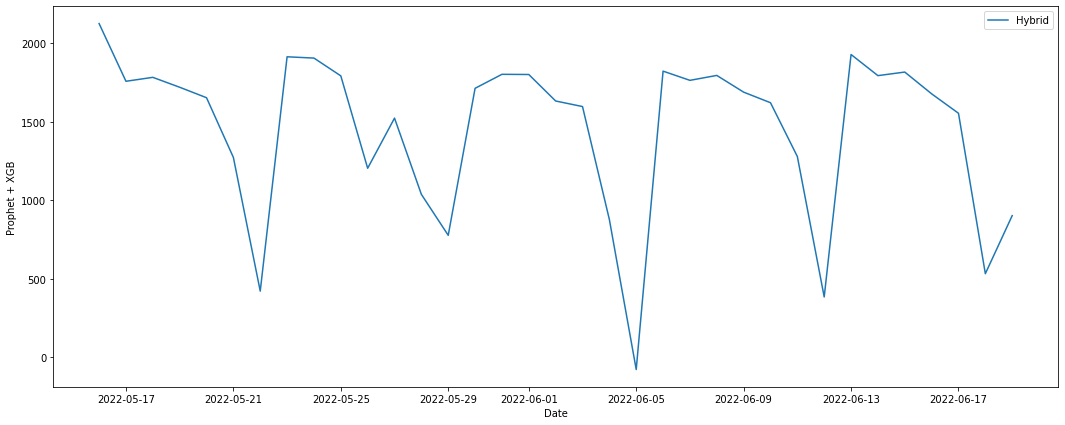

In [ ]:
plt.figure(figsize=(18, 7))
sns.lineplot(x= 'Date', y='Prophet + XGB', data= ensembled2, palette = colors, label = 'Hybrid')
# sns.lineplot(x= 'Date', y='Volume_Forecast', data= comparison, palette = colors, label = 'Verint Forecast')
# sns.lineplot(x= 'Date', y='Prophet', data= comparison, palette = colors, label = 'Prophet')
# sns.lineplot(x= 'Date', y='Ensembled', data= comparison, palette = colors, label = 'Ensembled')

# Correlation with the Customer Demand

**(1) Adjust dates that you would like to see the correlation** (*only in the red part)\
You can only review the correlation with the available data. So you can't set future values when you enter the date range for the correlation.

In [ ]:
minmaxcorr = pd.date_range(start="2022-04-01", end="2022-04-30", freq="D")
df_scaled_corr = df_scaled.reindex(minmaxcorr)

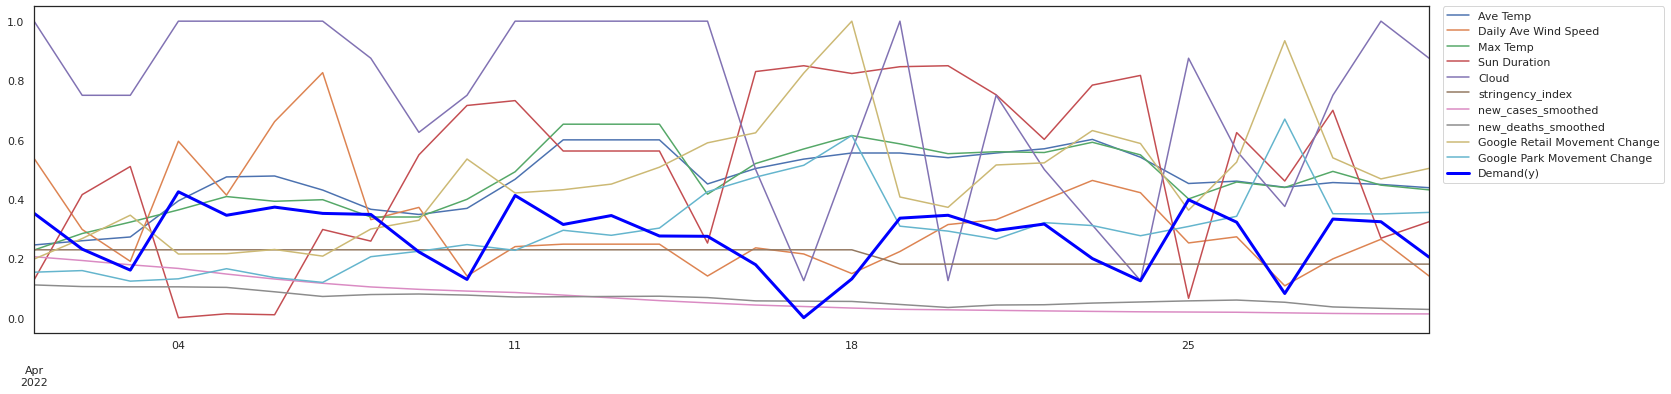

In [ ]:
df_scaled_corr.iloc[:,1:].plot(figsize = (25, 6), legend = True)
df_scaled_corr['Demand(y)'].plot(figsize = (25, 6), color = 'blue', linewidth = 3, legend = True)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

**(2) Correlation of selected features. The correlation value reflects what you see in the graph.**

In [ ]:
df_scaled_corr.corr()

Demand(y)  Ave Temp  Daily Ave Wind Speed  \
Demand(y)                       1.000000 -0.019929              0.434976   
Ave Temp                       -0.019929  1.000000             -0.106672   
Daily Ave Wind Speed            0.434976 -0.106672              1.000000   
Max Temp                       -0.146781  0.950155             -0.278976   
Sun Duration                   -0.490883  0.468958             -0.423894   
Cloud                           0.647552 -0.233643              0.161628   
stringency_index               -0.012251 -0.313260              0.167735   
new_cases_smoothed              0.227516 -0.688918              0.448636   
new_deaths_smoothed             0.167048 -0.595417              0.367800   
Google Retail Movement Change  -0.716949  0.446395             -0.600941   
Google Park Movement Change    -0.573417  0.412309             -0.626766   

                               Max Temp  Sun Duration     Cloud  \
Demand(y)                     -0.146781     -0.490883  0.647552   
Ave Temp                       0.950155      0.468958 -0.233643   
Daily Ave Wind Speed          -0.278976     -0.423894  0.161628   
Max Temp                       1.000000      0.645967 -0.270273   
Sun Duration                   0.645967      1.000000 -0.618632   
Cloud                         -0.270273     -0.618632  1.000000   
stringency_index              -0.254047     -0.251835  0.382369   
new_cases_smoothed            -0.667870     -0.527571  0.430348   
new_deaths_smoothed           -0.586046     -0.519720  0.400383   
Google Retail Movement Change  0.536754      0.591800 -0.567195   
Google Park Movement Change    0.465767      0.437664 -0.467744   

                               stringency_index  new_cases_smoothed  \
Demand(y)                             -0.012251            0.227516   
Ave Temp                              -0.313260           -0.688918   
Daily Ave Wind Speed                   0.167735            0.448636   
Max Temp                              -0.254047           -0.667870   
Sun Duration                          -0.251835           -0.527571   
Cloud                                  0.382369            0.430348   
stringency_index                       1.000000            0.705327   
new_cases_smoothed                     0.705327            1.000000   
new_deaths_smoothed                    0.758770            0.942365   
Google Retail Movement Change         -0.254890           -0.666491   
Google Park Movement Change           -0.289613           -0.696091   

                               new_deaths_smoothed  \
Demand(y)                                 0.167048   
Ave Temp                                 -0.595417   
Daily Ave Wind Speed                      0.367800   
Max Temp                                 -0.586046   
Sun Duration                             -0.519720   
Cloud                                     0.400383   
stringency_index                          0.758770   
new_cases_smoothed                        0.942365   
new_deaths_smoothed                       1.000000   
Google Retail Movement Change            -0.552678   
Google Park Movement Change              -0.594496   

                               Google Retail Movement Change  \
Demand(y)                                          -0.716949   
Ave Temp                                            0.446395   
Daily Ave Wind Speed                               -0.600941   
Max Temp                                            0.536754   
Sun Duration                                        0.591800   
Cloud                                              -0.567195   
stringency_index                                   -0.254890   
new_cases_smoothed                                 -0.666491   
new_deaths_smoothed                                -0.552678   
Google Retail Movement Change                       1.000000   
Google Park Movement Change                         0.928161   

                               Google Park

**(3) If you want to review some specific date range within the graph, you can change the dates below.**

In [ ]:
df_selectfeatures['2022-04-25':'2022-04-30']

Demand(y)  Ave Temp  Daily Ave Wind Speed  Max Temp  Sun Duration  \
2022-04-25     2703.0      88.0                  43.5     113.0          10.0   
2022-04-26     2188.0      90.5                  46.0     134.5          95.5   
2022-04-27      554.0      84.0                  26.0     127.5          70.5   
2022-04-28     2260.0      89.0                  37.0     148.0         107.0   
2022-04-29     2199.0      87.0                  45.0     130.5          41.0   
2022-04-30     1387.0      83.5                  30.0     124.5          49.5   

            Cloud  stringency_index  new_cases_smoothed  new_deaths_smoothed  \
2022-04-25    7.0             19.44            2388.714                9.143   
2022-04-26    4.5             19.44            2296.857                9.571   
2022-04-27    3.0             19.44            2044.714                8.429   
2022-04-28    6.0             19.44            1789.286                6.000   
2022-04-29    8.0             19.44            1654.857                5.286   
2022-04-30    7.0             19.44            1590.714                4.714   

            Google Retail Movement Change  Google Park Movement Change  
2022-04-25                      16.527223                    62.351482  
2022-04-26                      21.521663                    67.970151  
2022-04-27                      34.134851                   121.736005  
2022-04-28                      21.967174                    69.393344  
2022-04-29                      19.776685                    69.262952  
2022-04-30                      20.872181                    70.120930